In [109]:

# !pip install lightgbm

In [3]:
import json, gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from sklearn.cluster import KMeans
from scipy.special import comb
from copy import deepcopy
import random
from tqdm import tqdm
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.base import BaseEstimator
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from scipy.stats import multivariate_normal
import torch.distributions as D
from torch.utils.data import TensorDataset, DataLoader, Dataset
from scipy.interpolate import interp1d
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.metrics import mean_squared_error


## Thoughts on how to reduce runtime: 

1. Use only interesting frames

Pseudo Code: 

```Python
interesting_frames = set()

for _, event in events_df.iterrows():
    if event["type.name"] in ["Pass", "Carry", "Shot"]:
        sec = event["second"] + 60 * event["minute"]
        window_start = sec - 5
        window_end = sec + 5

        # Convert seconds → frame indices
        frame_start = int(window_start * frame_rate)
        frame_end = int(window_end * frame_rate)

        for f in range(frame_start, frame_end + 1):
            interesting_frames.add(f) 
```

Then slice your players_df:

```Python
players_df_window = players_df[
    players_df["frameIdx"].isin(interesting_frames)
]
```

2. Use Random Sampling


In [4]:



# n_files = 50 # or set to len(json_gz_paths) to load all
  
# frames = []
# players = []
# used_match_ids = []

# for file_idx, json_gz_path in enumerate(json_gz_paths[:n_files]):
#     match_id = json_gz_path.stem
#     used_match_ids.append(match_id)

#     # First pass: count lines
#     with gzip.open(json_gz_path, "rt", encoding="utf-8") as f:
#         total_lines = sum(1 for _ in f)

#     # Randomly select frame indices
#     n_sampled_frames = 500
#     sampled_indices = set(
#         np.random.choice(
#             total_lines,
#             size=min(n_sampled_frames, total_lines),
#             replace=False
#         )
#     )

#     # Second pass: read only sampled frames
#     with gzip.open(json_gz_path, "rt", encoding="utf-8") as f:
#         for i, line in enumerate(f):
#             if i not in sampled_indices:
#                 continue

#             r = json.loads(line)

#             f_data = {
#                 "match_id": match_id,
#                 "period": r["period"],
#                 "frameIdx": r["frameIdx"],
#                 "gameClock": r["gameClock"],
#                 "lastTouch_team": r["lastTouch"],
#                 "ball_x": r["ball"]["xyz"][0],
#                 "ball_y": r["ball"]["xyz"][1],
#                 "ball_z": r["ball"]["xyz"][2],
#             }
#             frames.append(f_data)

#             for side in ["homePlayers", "awayPlayers"]:
#                 for p in r[side]:
#                     px, py, pz = p["xyz"]
#                     players.append({
#                         "match_id": match_id,
#                         "period": r["period"],
#                         "frameIdx": r["frameIdx"],
#                         "side": "home" if side == "homePlayers" else "away",
#                         "playerId": p["playerId"],
#                         "optaId": str(p["optaId"]),
#                         "number": p["number"],
#                         "x": px, "y": py, "z": pz,
#                         "speed": p["speed"],
#                     })


TRACKING_DIR = pathlib.Path("tracking-compressed")
json_gz_paths = sorted(TRACKING_DIR.glob("tracking_*.json.gz"))

print(len(json_gz_paths), "tracking files found")

n_files = 10
frames = []
players = []
used_match_ids = []

for file_idx, json_gz_path in enumerate(json_gz_paths[:n_files]):
    match_id = json_gz_path.stem
    used_match_ids.append(match_id)

    # First pass: count total lines
    with gzip.open(json_gz_path, "rt", encoding="utf-8") as f:
        total_lines = sum(1 for _ in f)

    block_size = 250   # e.g. 10s * 25 fps
    num_blocks = 50

    max_possible_blocks = (total_lines - block_size) // block_size

    num_blocks_to_sample = min(num_blocks, max_possible_blocks)

    if num_blocks_to_sample <= 0:
        continue

    possible_starts = np.arange(
        0,
        total_lines - block_size + 1,
        block_size
    )

    rng = np.random.default_rng(42)
    chosen_starts = rng.choice(
        possible_starts,
        size=num_blocks_to_sample,
        replace=False
    )

    sampled_indices = set()

    for start in chosen_starts:
        sampled_indices.update(range(start, start + block_size))

    # Second pass: read only selected frames
    with gzip.open(json_gz_path, "rt", encoding="utf-8") as f:
        for i, line in enumerate(f):
            if i not in sampled_indices:
                continue

            r = json.loads(line)

            f_data = {
                "match_id": match_id,
                "period": r["period"],
                "frameIdx": r["frameIdx"],
                "gameClock": r["gameClock"],
                "lastTouch_team": r["lastTouch"],
                "ball_x": r["ball"]["xyz"][0],
                "ball_y": r["ball"]["xyz"][1],
                "ball_z": r["ball"]["xyz"][2],
            }
            frames.append(f_data)

            for side in ["homePlayers", "awayPlayers"]:
                for p in r[side]:
                    px, py, pz = p["xyz"]
                    players.append({
                        "match_id": match_id,
                        "period": r["period"],
                        "frameIdx": r["frameIdx"],
                        "side": "home" if side == "homePlayers" else "away",
                        "playerId": p["playerId"],
                        "optaId": str(p["optaId"]),
                        "number": p["number"],
                        "x": px, "y": py, "z": pz,
                        "speed": p["speed"],
                    })

frames_df = pd.DataFrame(frames)
players_df = pd.DataFrame(players)

1127 tracking files found


In [6]:
print(f"\n players df \n", players_df.head())
print(f"\n frames df \n", frames_df.head())


 players df 
                  match_id  period  frameIdx  side  \
0  tracking_g2292810.json       1      8750  home   
1  tracking_g2292810.json       1      8750  home   
2  tracking_g2292810.json       1      8750  home   
3  tracking_g2292810.json       1      8750  home   
4  tracking_g2292810.json       1      8750  home   

                               playerId  optaId  number      x      y    z  \
0  281b8199-4222-423e-a0b1-8d53a5ba63e4  209036       6 -41.69 -14.48  0.0   
1  3b1a932d-9194-41bb-b42c-ef51abce311d   82403      11 -12.81  -4.30  0.0   
2  54166880-dabd-4edd-9318-848383c2f92f  232413      10 -24.68 -22.17  0.0   
3  5d440daa-6639-47c6-bf5b-ecb56a88272d  174874      16 -49.25 -32.57  0.0   
4  6dfa5972-07f6-4be3-a2f5-be1e7336c5fd  438464      28 -35.39 -23.52  0.0   

   speed  
0   0.41  
1   1.08  
2   0.72  
3   0.77  
4   0.60  

 frames df 
                  match_id  period  frameIdx  gameClock lastTouch_team  ball_x  \
0  tracking_g2292810.json       1   

In [113]:
# def sample_tracking_segments(players_df, frames_df,
#                              num_segments=10,
#                              segment_duration_sec=5,
#                              frame_rate=25.0,
#                              random_state=None):
#     """
#     Randomly samples time segments from tracking data.

#     Returns:
#         players_df_sampled, frames_df_sampled
#     """

#     sampled_frames = set()

#     for (match_id, period), group in frames_df.groupby(["match_id", "period"]):

#         max_frame = group["frameIdx"].max()
#         total_seconds = max_frame / frame_rate

#         if total_seconds < segment_duration_sec:
#             continue  # skip short halves

#         # Possible start times in seconds
#         possible_starts = np.arange(
#             0,
#             total_seconds - segment_duration_sec,
#             step=1
#         )

#         if len(possible_starts) == 0:
#             continue

#         rng = np.random.default_rng(random_state)
#         chosen_starts_sec = rng.choice(
#             possible_starts,
#             size=min(num_segments, len(possible_starts)),
#             replace=False
#         )

#         for start_sec in chosen_starts_sec:
#             start_frame = int(start_sec * frame_rate)
#             end_frame = start_frame + int(segment_duration_sec * frame_rate)

#             frames_in_segment = range(start_frame, end_frame + 1)
#             sampled_frames.update(
#                 (match_id, period, f) for f in frames_in_segment
#             )

#     # Filter players_df and frames_df
#     sampled_frames_df = pd.DataFrame(
#         list(sampled_frames),
#         columns=["match_id", "period", "frameIdx"]
#     )

#     players_df_sampled = players_df.merge(
#         sampled_frames_df,
#         on=["match_id", "period", "frameIdx"],
#         how="inner"
#     )

#     frames_df_sampled = frames_df.merge(
#         sampled_frames_df,
#         on=["match_id", "period", "frameIdx"],
#         how="inner"
#     )

#     return players_df_sampled, frames_df_sampled

# # Sample tracking segments
# players_df, frames_df = sample_tracking_segments(
#     players_df,
#     frames_df,
#     num_segments=50,
#     segment_duration_sec=10,
#     random_state=42
# )


In [114]:
print(frames_df)

print(players_df.shape)

print(frames_df.shape)

                      match_id  period  frameIdx  gameClock lastTouch_team  \
0       tracking_g2292810.json       1      8750     350.00           away   
1       tracking_g2292810.json       1      8751     350.04           away   
2       tracking_g2292810.json       1      8752     350.08           away   
3       tracking_g2292810.json       1      8753     350.12           away   
4       tracking_g2292810.json       1      8754     350.16           away   
...                        ...     ...       ...        ...            ...   
624995  tracking_g2292859.json       2    143995    2917.20           away   
624996  tracking_g2292859.json       2    143996    2917.24           away   
624997  tracking_g2292859.json       2    143997    2917.28           away   
624998  tracking_g2292859.json       2    143998    2917.32           away   
624999  tracking_g2292859.json       2    143999    2917.36           away   

        ball_x  ball_y  ball_z  
0         0.00    0.00  -10.00

In [7]:
def extract_event_metadata(events_path):
    teams = set()
    match_date = None

    with open(events_path, "r", encoding="utf-8-sig") as f:
        for line in f:
            obj = json.loads(line)
            
            # Grab match date
            if match_date is None and "match_date" in obj:
                match_date = obj["match_date"]

            # Grab team names
            if "team" in obj and obj["team"] is not None:
                team_name = obj["team"]["name"]
                teams.add(team_name)
            if "possession_team" in obj and obj["possession_team"] is not None:
                team_name = obj["possession_team"]["name"]
                teams.add(team_name)

    return {
        "events_file": str(events_path),
        "match_date": match_date,
        "team_names": list(teams),
    }

# Assume your event files are in a directory named 'events'
EVENTS_DIR = pathlib.Path("statsbomb_pl_data")
event_files = sorted(EVENTS_DIR.glob("*.json"))

event_metadata_records = []

for event_file in event_files:
    meta = extract_event_metadata(event_file)
    event_metadata_records.append(meta)

event_meta_df = pd.DataFrame(event_metadata_records)

print(event_meta_df.head())

                      events_file  match_date  \
0  statsbomb_pl_data/3837230.json  2022-08-05   
1  statsbomb_pl_data/3837231.json  2022-08-06   
2  statsbomb_pl_data/3837232.json  2022-08-07   
3  statsbomb_pl_data/3837233.json  2022-08-06   
4  statsbomb_pl_data/3837234.json  2022-08-06   

                                team_names  
0                [Crystal Palace, Arsenal]  
1  [Leeds United, Wolverhampton Wanderers]  
2              [Leicester City, Brentford]  
3    [Nottingham Forest, Newcastle United]  
4         [Southampton, Tottenham Hotspur]  


In [10]:

# Collect all metadata files
metadata_dir = pathlib.Path("metadata_SecondSpectrum")
all_metadata_files = list(metadata_dir.glob("*.json"))

tracking_meta_records = []

for path in all_metadata_files:
    with open(path, "r", encoding="utf-8-sig") as f:
        meta = json.load(f)

    # Build match_date from year, month, day
    if all(k in meta for k in ["year", "month", "day"]):
        match_date = f"{meta['year']:04}-{meta['month']:02}-{meta['day']:02}"
    else:
        match_date = None

    # Parse teams from description
    desc = meta.get("description", "")
    home_team, away_team = None, None
    if " - " in desc:
        teams_part = desc.split(":")[0].strip()
        home_team, away_team = teams_part.split(" - ")

    # Get tracking suffix from filename
    if path.stem.startswith("metadata_g"):
        suffix = path.stem.split("_")[1]
    else:
        suffix = path.stem.split("_")[0]

    tracking_meta_records.append({
        "metadata_path": str(path),
        "tracking_suffix": suffix,
        "match_date": match_date,
        "home_team": home_team,
        "away_team": away_team,
    })

tracking_meta_df = pd.DataFrame(tracking_meta_records)
print(tracking_meta_df.head())

                                       metadata_path tracking_suffix  \
0     metadata_SecondSpectrum/metadata_g2444536.json        g2444536   
1  metadata_SecondSpectrum/g2292852_SecondSpectru...        g2292852   
2     metadata_SecondSpectrum/metadata_g2444473.json        g2444473   
3  metadata_SecondSpectrum/g2293073_SecondSpectru...        g2293073   
4  metadata_SecondSpectrum/g2367750_SecondSpectru...        g2367750   

   match_date home_team away_team  
0  2024-10-05       EVE       NEW  
1  2022-08-30       CRY       BRE  
2  2024-08-17       IPS       LIV  
3  2023-03-12       FUL       ARS  
4  2024-01-30       FUL       EVE  


In [11]:
team_code_map = {'FUL': 'Fulham',
                'BRE': 'Brentford',
                'CRY': 'Crystal Palace', 
                'TOT': 'Tottenham Hotspur', 
                'BOU': 'AFC Bournemouth', 
                'SOU': 'Southampton',
                'AVL': 'Aston Villa', 
                'WHU': 'West Ham United', 
                'MUN': 'Manchester United',
                'ARS': 'Arsenal', 
                'LEI': 'Leicester City',
                'NEW': 'Newcastle United',
                'BHA': 'Brighton & Hove Albion',
                'IPS': 'Ipswich Town', 
                'EVE': 'Everton', 
                'LIV': 'Liverpool',
                'LEE': 'Leeds United', 
                'NOT': 'Nottingham Forest',
                'MCI': 'Manchester City', 
                'WOL': 'Wolverhampton Wanderers',
                'SHU': 'Sheffield United',
                'CHE': 'Chelsea', 
                'LUT': 'Luton Town', 
                'BUR': 'Burnley'}

print(" TEAM CODE MAP:")
print(team_code_map)

 TEAM CODE MAP:
{'FUL': 'Fulham', 'BRE': 'Brentford', 'CRY': 'Crystal Palace', 'TOT': 'Tottenham Hotspur', 'BOU': 'AFC Bournemouth', 'SOU': 'Southampton', 'AVL': 'Aston Villa', 'WHU': 'West Ham United', 'MUN': 'Manchester United', 'ARS': 'Arsenal', 'LEI': 'Leicester City', 'NEW': 'Newcastle United', 'BHA': 'Brighton & Hove Albion', 'IPS': 'Ipswich Town', 'EVE': 'Everton', 'LIV': 'Liverpool', 'LEE': 'Leeds United', 'NOT': 'Nottingham Forest', 'MCI': 'Manchester City', 'WOL': 'Wolverhampton Wanderers', 'SHU': 'Sheffield United', 'CHE': 'Chelsea', 'LUT': 'Luton Town', 'BUR': 'Burnley'}


In [12]:
tracking_meta_df["home_team_full"] = tracking_meta_df["home_team"].map(team_code_map)
tracking_meta_df["away_team_full"] = tracking_meta_df["away_team"].map(team_code_map)

tracking_meta_long = pd.concat([
    tracking_meta_df.assign(team_name=tracking_meta_df["home_team_full"]),
    tracking_meta_df.assign(team_name=tracking_meta_df["away_team_full"]),
])

tracking_meta_long["key"] = (
    tracking_meta_long["match_date"].fillna("") + "_" +
    tracking_meta_long["team_name"].fillna("")
)

event_meta_exploded = event_meta_df.explode("team_names")
event_meta_exploded["team_name"] = event_meta_exploded["team_names"].fillna("")

event_meta_exploded["key"] = (
    event_meta_exploded["match_date"].fillna("") + "_" +
    event_meta_exploded["team_name"].fillna("")
)

event_tracking_df = event_meta_exploded.merge(
    tracking_meta_long,
    on="key",
    how="left",
    suffixes=("", "_tracking")
)

print(event_tracking_df.head())

                      events_file  match_date               team_names  \
0  statsbomb_pl_data/3837230.json  2022-08-05           Crystal Palace   
1  statsbomb_pl_data/3837230.json  2022-08-05                  Arsenal   
2  statsbomb_pl_data/3837231.json  2022-08-06             Leeds United   
3  statsbomb_pl_data/3837231.json  2022-08-06  Wolverhampton Wanderers   
4  statsbomb_pl_data/3837232.json  2022-08-07           Leicester City   

                 team_name                                 key  \
0           Crystal Palace           2022-08-05_Crystal Palace   
1                  Arsenal                  2022-08-05_Arsenal   
2             Leeds United             2022-08-06_Leeds United   
3  Wolverhampton Wanderers  2022-08-06_Wolverhampton Wanderers   
4           Leicester City           2022-08-07_Leicester City   

                                       metadata_path tracking_suffix  \
0  metadata_SecondSpectrum/g2292810_SecondSpectru...        g2292810   
1  metadata_Se

In [13]:
event_tracking_df_clean = (
    event_tracking_df
    .dropna(subset=["tracking_suffix"])
    .drop_duplicates(subset=["events_file"])
    .reset_index(drop=True)
)
print(event_tracking_df_clean.head())

                      events_file  match_date         team_names  \
0  statsbomb_pl_data/3837230.json  2022-08-05     Crystal Palace   
1  statsbomb_pl_data/3837231.json  2022-08-06       Leeds United   
2  statsbomb_pl_data/3837232.json  2022-08-07     Leicester City   
3  statsbomb_pl_data/3837233.json  2022-08-06  Nottingham Forest   
4  statsbomb_pl_data/3837234.json  2022-08-06        Southampton   

           team_name                           key  \
0     Crystal Palace     2022-08-05_Crystal Palace   
1       Leeds United       2022-08-06_Leeds United   
2     Leicester City     2022-08-07_Leicester City   
3  Nottingham Forest  2022-08-06_Nottingham Forest   
4        Southampton        2022-08-06_Southampton   

                                       metadata_path tracking_suffix  \
0  metadata_SecondSpectrum/g2292810_SecondSpectru...        g2292810   
1  metadata_SecondSpectrum/g2292814_SecondSpectru...        g2292814   
2  metadata_SecondSpectrum/g2292815_SecondSpectru.

In [ ]:
# Add absolute seconds column
def add_event_timestamps(events_df):
    events_df["minute"] = events_df["minute"].fillna(0).astype(int)
    events_df["second"] = events_df["second"].fillna(0).astype(int)

    if "milliseconds" in events_df.columns:
        events_df["milliseconds"] = events_df["milliseconds"].fillna(0).astype(int)
    else:
        events_df["milliseconds"] = 0

    # events_df["seconds_period"] = (
    #     events_df["minute"] * 60 +
    #     events_df["second"] +
    #     events_df["milliseconds"] / 1000
    # )

    # Compute absolute seconds within game (cumulative time)
    events_df["seconds_absolute"] = (
        events_df["minute"] * 60 +
        events_df["second"] +
        events_df["milliseconds"] / 1000
    )

    # Normalize per period (so it starts from 0 each period)
    #events_df["seconds_period"] = events_df.groupby("period")["seconds_absolute"].transform(lambda x: x - x.min())
    events_df["seconds_period"] = events_df["seconds_absolute"]  # rename for compatibility if needed
    return events_df

def match_events_to_frames(events_df, frames_df_match):
    """
    Assigns nearest frameIdx to each event.
    """
    period_to_frame_times = {}
    for period, group in frames_df_match.groupby("period"):
        period_to_frame_times[period] = group[["seconds_period", "frameIdx"]].sort_values("seconds_period")

    assigned_frames = []
    frame_diffs = []  # Optional: debug how far match is from original timestamp

    for _, e in events_df.iterrows():
        period = e["period"]
        seconds_event = e["seconds_period"]

        if period not in period_to_frame_times:
            assigned_frames.append(None)
            frame_diffs.append(None)
            continue

        times = period_to_frame_times[period]["seconds_period"].values
        frames = period_to_frame_times[period]["frameIdx"].values

        # Find closest frame
        idx = np.argmin(np.abs(times - seconds_event))
        assigned_frame = frames[idx]
        diff = np.abs(times[idx] - seconds_event)

        assigned_frames.append(assigned_frame)
        frame_diffs.append(diff)

    events_df["frameIdx"] = assigned_frames
    events_df["frame_diff"] = frame_diffs  # Optional: useful debug column
    return events_df


def find_events_during_run(run_df, events_df):
    """
    Given a single run DataFrame and events_df
    returns list of events that overlap this run
    """
    period = run_df["period"].iloc[0]
    start_frame = run_df["frameIdx"].min()
    end_frame = run_df["frameIdx"].max()

    overlapping_events = events_df[
        (events_df["period"] == period) &
        (events_df["frameIdx"] >= start_frame) &
        (events_df["frameIdx"] <= end_frame)
    ]
    return overlapping_events

import os

#force_reload = True  #  Set to True when debugging new logic
#debug_match_ids = {"tracking_g2292810"}

# Get list of actual tracking files in frames_df
valid_tracking_ids = set(frames_df["match_id"].unique())  # e.g. {'tracking_g2292810', ...}

# Filter event_tracking_df_clean to only rows with those tracking files
filtered_event_tracking_df = event_tracking_df_clean[
    event_tracking_df_clean["tracking_suffix"].apply(lambda s: f"tracking_{s}") \
    .isin(valid_tracking_ids)
]
# Normalise match_id format in advance
frames_df["match_id"] = frames_df["match_id"].str.replace(".json", "", regex=False)
players_df["match_id"] = players_df["match_id"].str.replace(".json", "", regex=False)

#if os.path.exists("events_dfs_by_match.joblib") and not force_reload:
if os.path.exists("events_dfs_by_match.joblib"):
    events_dfs_by_match = joblib.load("events_dfs_by_match.joblib")
    print(" Loaded precomputed events_dfs_by_match.")
else:
    # run original block:
    events_dfs_by_match = {}

    for _, row in filtered_event_tracking_df.iterrows():

        events_path = row["events_file"]
        tracking_suffix = row["tracking_suffix"]
        tracking_match_id = f"tracking_{tracking_suffix}"

        # if tracking_match_id not in debug_match_ids:
        #     continue

        # print("tracking_match_id:", tracking_match_id)
        # print("Available match_ids in frames_df:", frames_df["match_id"].unique()[:5])

        frames_df_match = frames_df[frames_df["match_id"] == tracking_match_id]
        players_df_match = players_df[players_df["match_id"] == tracking_match_id]
        # print(frames_df_match.shape, players_df_match.shape)
        # print(f"\nframes_df_match\n", frames_df_match.head())
        # print(f"\nplayers_df_match\n", players_df_match.head())

        with open(events_path, "r", encoding="utf-8-sig") as f:
            event_rows = [json.loads(line) for line in f]

        events_df = pd.DataFrame(event_rows)
        events_df = add_event_timestamps(events_df)

        # print("Events period distribution:")
        # print(events_df["period"].value_counts().sort_index())

        # print("\nFrames period distribution:")
        # print(frames_df_match["period"].value_counts().sort_index())

        frames_df_match["seconds_period"] = frames_df_match.apply(
            lambda row: row["gameClock"] + (0 if row["period"] == 1 else 2700),
            axis=1
        )

        #print("\nMax seconds_period per period (events):")
        #print(events_df.groupby("period")["seconds_period"].max())

        #print("\nMax seconds_period per period (frames):")
        #print(frames_df_match.groupby("period")["seconds_period"].max())

        # tracking_start_sec = frames_df_match["seconds_period"].min()
        # events_df = events_df[events_df["seconds_period"] >= tracking_start_sec]
        # Filter events that occur before tracking data starts in each period
        valid_periods = frames_df_match["period"].unique()

        filtered_events = []
        for period in valid_periods:
            frames_period = frames_df_match[frames_df_match["period"] == period]
            events_period = events_df[events_df["period"] == period]

            if frames_period.empty or events_period.empty:
                print(f"[SKIP] Empty data for period {period} in match {tracking_match_id}")
                continue

            start_sec = frames_period["seconds_period"].min()
            #print(f"[DEBUG] Match {tracking_match_id} | Period {period} starts at {start_sec:.2f}s")
            filtered = events_period[events_period["seconds_period"] >= start_sec]
            #print(f"[DEBUG] → Kept {len(filtered)} / {len(events_period)} events")
            filtered_events.append(filtered)

        events_df = pd.concat(filtered_events, ignore_index=True)
      
        events_df = match_events_to_frames(events_df, frames_df_match)

        # print(f"\n===  events_df after matching ===")
        # print(events_df[["type", "seconds_period", "frameIdx", "frame_diff", "period"]].head(20))

        null_count = events_df["frameIdx"].isnull().sum()
        #print(f"Null frameIdxs: {null_count} / {len(events_df)}")

        events_dfs_by_match[tracking_match_id] = events_df

    joblib.dump(events_dfs_by_match, "events_dfs_by_match.joblib")
    print(" Saved events_dfs_by_match to disk.")




/var/folders/kt/gmkq5dyj63s1r35swbwrg5jr0000gn/T/ipykernel_26843/2920183999.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frames_df_match["seconds_period"] = frames_df_match.apply(


[DEBUG] Match tracking_g2292810 | Period 1 starts at 350.00s
[DEBUG] → Kept 1698 / 2033 events
[DEBUG] Match tracking_g2292810 | Period 2 starts at 2708.48s
[DEBUG] → Kept 1760 / 1773 events


/var/folders/kt/gmkq5dyj63s1r35swbwrg5jr0000gn/T/ipykernel_26843/2920183999.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frames_df_match["seconds_period"] = frames_df_match.apply(


[DEBUG] Match tracking_g2292814 | Period 1 starts at 360.00s
[DEBUG] → Kept 1466 / 1712 events
[DEBUG] Match tracking_g2292814 | Period 2 starts at 2713.88s
[DEBUG] → Kept 1805 / 1818 events


/var/folders/kt/gmkq5dyj63s1r35swbwrg5jr0000gn/T/ipykernel_26843/2920183999.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frames_df_match["seconds_period"] = frames_df_match.apply(


[DEBUG] Match tracking_g2292815 | Period 1 starts at 350.00s
[DEBUG] → Kept 1795 / 2105 events
[DEBUG] Match tracking_g2292815 | Period 2 starts at 2708.40s
[DEBUG] → Kept 1553 / 1564 events


/var/folders/kt/gmkq5dyj63s1r35swbwrg5jr0000gn/T/ipykernel_26843/2920183999.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frames_df_match["seconds_period"] = frames_df_match.apply(


[DEBUG] Match tracking_g2292816 | Period 1 starts at 350.00s
[DEBUG] → Kept 1426 / 1637 events
[DEBUG] Match tracking_g2292816 | Period 2 starts at 2886.48s
[DEBUG] → Kept 1401 / 1496 events


/var/folders/kt/gmkq5dyj63s1r35swbwrg5jr0000gn/T/ipykernel_26843/2920183999.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frames_df_match["seconds_period"] = frames_df_match.apply(


[DEBUG] Match tracking_g2292817 | Period 1 starts at 350.00s
[DEBUG] → Kept 1617 / 1827 events
[DEBUG] Match tracking_g2292817 | Period 2 starts at 2859.16s
[DEBUG] → Kept 1728 / 1807 events


/var/folders/kt/gmkq5dyj63s1r35swbwrg5jr0000gn/T/ipykernel_26843/2920183999.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frames_df_match["seconds_period"] = frames_df_match.apply(


[DEBUG] Match tracking_g2292812 | Period 1 starts at 410.00s
[DEBUG] → Kept 1370 / 1646 events
[DEBUG] Match tracking_g2292812 | Period 2 starts at 2700.00s
[DEBUG] → Kept 1769 / 1769 events


/var/folders/kt/gmkq5dyj63s1r35swbwrg5jr0000gn/T/ipykernel_26843/2920183999.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frames_df_match["seconds_period"] = frames_df_match.apply(


[DEBUG] Match tracking_g2292813 | Period 1 starts at 360.00s
[DEBUG] → Kept 1606 / 1858 events
[DEBUG] Match tracking_g2292813 | Period 2 starts at 2702.96s
[DEBUG] → Kept 1633 / 1639 events


/var/folders/kt/gmkq5dyj63s1r35swbwrg5jr0000gn/T/ipykernel_26843/2920183999.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frames_df_match["seconds_period"] = frames_df_match.apply(


[DEBUG] Match tracking_g2292811 | Period 1 starts at 370.00s
[DEBUG] → Kept 1554 / 1702 events
[DEBUG] Match tracking_g2292811 | Period 2 starts at 2736.40s
[DEBUG] → Kept 1658 / 1711 events


/var/folders/kt/gmkq5dyj63s1r35swbwrg5jr0000gn/T/ipykernel_26843/2920183999.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frames_df_match["seconds_period"] = frames_df_match.apply(


[DEBUG] Match tracking_g2292819 | Period 1 starts at 360.00s
[DEBUG] → Kept 1585 / 1768 events
[DEBUG] Match tracking_g2292819 | Period 2 starts at 2823.08s
[DEBUG] → Kept 1924 / 2044 events


/var/folders/kt/gmkq5dyj63s1r35swbwrg5jr0000gn/T/ipykernel_26843/2920183999.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frames_df_match["seconds_period"] = frames_df_match.apply(


[DEBUG] Match tracking_g2292818 | Period 1 starts at 360.00s
[DEBUG] → Kept 1363 / 1555 events
[DEBUG] Match tracking_g2292818 | Period 2 starts at 2705.20s
[DEBUG] → Kept 1687 / 1695 events
 Saved events_dfs_by_match to disk.


In [126]:
for a, row in event_tracking_df_clean.iterrows(): 
    print(row["tracking_suffix"])



g2292810
g2292814
g2292815
g2292816
g2292817
g2292812
g2292813
g2292811
g2292819
g2292818
g2292829
g2292820
g2292821
g2292822
g2292823
g2292824
g2292825
g2292826
g2292827
g2292828
g2292830
g2292831
g2292832
g2292833
g2292834
g2292835
g2292836
g2292837
g2292838
g2292839
g2292840
g2292841
g2292842
g2292843
g2292844
g2292845
g2292846
g2292847
g2292848
g2292849
g2292850
g2292851
g2292853
g2292854
g2292855
g2292856
g2292852
g2292859
g2292857
g2292858
g2292860
g2292861
g2292862
g2292863
g2292864
g2292865
g2292866
g2292867
g2292868
g2292869
g2292870
g2292871
g2292872
g2292873
g2292874
g2292875
g2292876
g2292877
g2292878
g2292879
g2292880
g2292881
g2292882
g2292883
g2292884
g2292885
g2292886
g2292887
g2292888
g2292889
g2292895
g2292890
g2292891
g2292892
g2292893
g2292894
g2292896
g2292897
g2292898
g2292899
g2292900
g2292908
g2292909
g2292901
g2292902
g2292903
g2292904
g2292905
g2292906
g2292907
g2292911
g2292912
g2292913
g2292914
g2292915
g2292916
g2292910
g2292917
g2292918
g2292919
g2292925
g

In [17]:
print("Number of matches in events_dfs_by_match:", len(events_dfs_by_match))
print("Match IDs in events_dfs_by_match:", list(events_dfs_by_match.keys()))


Number of matches in events_dfs_by_match: 10
Match IDs in events_dfs_by_match: ['tracking_g2292810', 'tracking_g2292814', 'tracking_g2292815', 'tracking_g2292816', 'tracking_g2292817', 'tracking_g2292812', 'tracking_g2292813', 'tracking_g2292811', 'tracking_g2292819', 'tracking_g2292818']


 Frame Idx: 8999
Event 0: Pass by Nathaniel Edwin Clyne at 364.0 seconds
 Frame Idx: 8999
Event 1: Pressure at 365.0 seconds
 Frame Idx: 8999
Event 2: Ball Receipt* at 365.0 seconds
 Frame Idx: 8999
Event 3: Carry at 365.0 seconds
 Frame Idx: 8999
Event 4: Miscontrol at 365.0 seconds
 Frame Idx: 8999
Event 5: Pass by Oleksandr Zinchenko at 367.0 seconds
 Frame Idx: 8999
Event 6: Ball Receipt* at 368.0 seconds
 Frame Idx: 8999
Event 7: Carry at 368.0 seconds
 Frame Idx: 8999
Event 8: Miscontrol at 368.0 seconds
 Frame Idx: 8999
Event 9: Pressure at 369.0 seconds
 Frame Idx: 8999
Event 10: Pass by Jeffrey Schlupp at 369.0 seconds
 Frame Idx: 9500
Event 11: Ball Receipt* at 371.0 seconds
 Frame Idx: 9500
Event 12: Carry at 371.0 seconds
 Frame Idx: 9500
Event 13: Pressure at 373.0 seconds
 Frame Idx: 9500
Event 14: Pass by Wilfried Zaha at 373.0 seconds
 Frame Idx: 9500
Event 15: Pressure at 375.0 seconds
 Frame Idx: 9500
Event 16: Ball Receipt* at 377.0 seconds
 Frame Idx: 9500
Event 17:

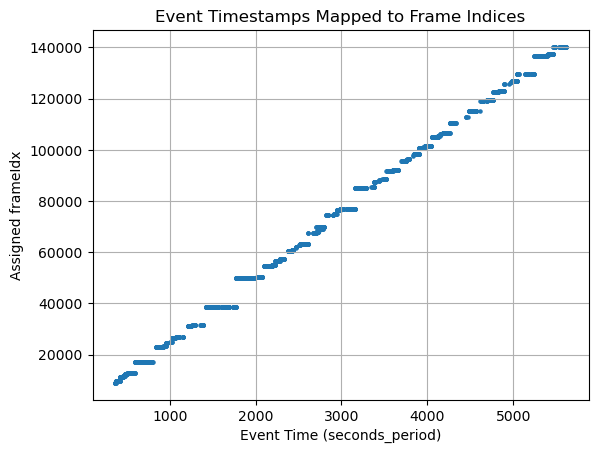

Max frame_diff (sec): 220.0
Mean frame_diff (sec): 43.68137651821849
Min frame_diff (sec): 0.0
Total events: 3458
Median frame_diff (sec): 32.0
Mode frame_diff (sec): 0    0.0
Name: frame_diff, dtype: float64
Number of Mode frame_diff occurences (sec): 329


In [18]:

debug_match_id = "tracking_g2292810"
events_df = events_dfs_by_match[debug_match_id]

# print(events_df)
# print(events_df.columns.tolist())

for num, e in events_df.iterrows(): 
    num_pass = 0
    total = 0
    print(f" Frame Idx:", e["frameIdx"])
    if e["type"]["name"] == 'Pass':
        num_pass += 1
        print(f"Event {num}: {e['type']['name']} by {e['player']['name']} at {e['seconds_period']} seconds")
        total += 1
    else: 
        total += 1
        print(f"Event {num}: {e['type']['name']} at {e['seconds_period']} seconds")

plt.scatter(events_df["seconds_period"], events_df["frameIdx"], s=5)
plt.xlabel("Event Time (seconds_period)")
plt.ylabel("Assigned frameIdx")
plt.title("Event Timestamps Mapped to Frame Indices")
plt.grid(True)
plt.show()
    
print("Max frame_diff (sec):", events_df["frame_diff"].max())
print("Mean frame_diff (sec):", events_df["frame_diff"].mean())
print("Min frame_diff (sec):", events_df["frame_diff"].min())
print("Total events:", len(events_df))
print("Median frame_diff (sec):", events_df["frame_diff"].median())
mode = events_df["frame_diff"].mode()[0]
print("Mode frame_diff (sec):", events_df["frame_diff"].mode())
print("Number of Mode frame_diff occurences (sec):", (events_df["frame_diff"] == mode).sum())



# print(f"\n=== events_df for {debug_match_id} ===")
# print(events_df[["type", "minute", "second", "seconds_period", "frameIdx"]].head(10))
# print("Total events:", len(events_df))
# print("Null frameIdx values:", events_df["frameIdx"].isnull().sum())
# print("FrameIdx value range:", events_df["frameIdx"].min(), "-", events_df["frameIdx"].max())



In [19]:
missing_events = events_df[events_df["frameIdx"].isnull()]
print("Missing events by type:", missing_events["type"].apply(lambda x: x.get("name") if isinstance(x, dict) else None).value_counts())

Missing events by type: Series([], Name: count, dtype: int64)


In [20]:
print("Assigned frameIdxs to events:")
print(events_df[["seconds_period", "frameIdx"]].head(10))
print("Any nulls?", events_df["frameIdx"].isnull().sum())

# sample_match_id = list(events_dfs_by_match.keys())[0]

# # Grab its DataFrame
# events_df = events_dfs_by_match[sample_match_id]

# # View basic info
# #print(events_df.head(20))
# print(events_df.columns)
# print(events_df.shape)

Assigned frameIdxs to events:
   seconds_period  frameIdx
0           364.0      8999
1           365.0      8999
2           365.0      8999
3           365.0      8999
4           365.0      8999
5           367.0      8999
6           368.0      8999
7           368.0      8999
8           368.0      8999
9           369.0      8999
Any nulls? 0


In [21]:
# Step 1: Extract suffixes like "g2444470" from used tracking files
used_match_suffixes = [match_id.split("_", 1)[1].replace(".json", "") for match_id in used_match_ids]

# Step 2: Gather metadata file paths from both formats
metadata_dir = pathlib.Path("metadata_SecondSpectrum")
all_metadata_files = list(metadata_dir.glob("*.json"))

# Build map: match_suffix (e.g., "g2444470") → metadata_path
metadata_file_map = {}
for path in all_metadata_files:
    filename = path.name
    if filename.startswith("metadata_g") and filename.endswith(".json"):
        suffix = filename.split("_")[1].split(".")[0]  # 'g2444470'
    elif filename.endswith("_SecondSpectrum_Metadata.json"):
        suffix = filename.split("_")[0]  # 'g2444470'
    else:
        continue  # skip non-matching files
    metadata_file_map[suffix] = path

# Build a lookup DataFrame linking tracking suffixes to match date and teams
tracking_meta_records = []
for suffix, metadata_path in metadata_file_map.items():
    with open(metadata_path, "r", encoding="utf-8-sig") as f:
        meta = json.load(f)
    tracking_meta_records.append({
        "match_date": meta.get("matchDate"),
        "home_team": meta.get("homeTeamName"),
        "away_team": meta.get("awayTeamName"),
        "tracking_suffix": suffix,
        "metadata_path": str(metadata_path),
    })


# Step 3: Load metadata and build lookup for used matches
opta_meta_lookup = {}

for suffix in used_match_suffixes:
    metadata_path = metadata_file_map.get(suffix)
    if not metadata_path:
        print(f" No metadata found for match {suffix}")
        continue

    with open(metadata_path, "r", encoding="utf-8-sig") as f:
        meta = json.load(f)

    match_id = f"tracking_{suffix}"  # same format as tracking match_id

    for side, team in [("homePlayers", "home"), ("awayPlayers", "away")]:
        for p in meta.get(side, []):
            key = (match_id, str(p["optaId"]))
            opta_meta_lookup[key] = {
                "player_name": p.get("name"),
                "position": p.get("position"),
                "team_role": team,
            }

print(f" Loaded metadata for {len(opta_meta_lookup)} players.")

meta_df = pd.DataFrame([
    {
        "match_id": match_id,
        "optaId": opta_id,
        "player_name": info["player_name"],
        "position": info["position"],
        "team_role": info["team_role"],
    }
    for (match_id, opta_id), info in opta_meta_lookup.items()
])

players_df["match_id_clean"] = players_df["match_id"].str.replace(".json", "", regex=False)

# Merge using match_id and optaId as keys
players_df = players_df.merge(
    meta_df,
    how="left",
    left_on=["match_id_clean", "optaId"],
    right_on=["match_id", "optaId"]
)

players_df.drop(columns=["match_id_clean", "match_id_y"], inplace=True)
players_df.rename(columns={"match_id_x": "match_id"}, inplace=True)

# # Build name→optaId lookup
# metadata_df = meta_df.copy()

# metadata_df["player_name_clean"] = metadata_df["player_name"].str.lower().str.strip()
# metadata_dict = dict(
#     zip(metadata_df["player_name_clean"], metadata_df["optaId"].astype(str))
# )


def extract_surname(name):
    if pd.isna(name) or name is None:
        return ""
    name = name.lower().strip()
    parts = name.split()
    if len(parts) == 0:
        return ""
    return parts[-1]

metadata_df = meta_df.copy()

metadata_df["surname"] = metadata_df["player_name"].apply(extract_surname)
metadata_dict = dict(
    zip(metadata_df["surname"], metadata_df["optaId"].astype(str))
)



 Loaded metadata for 400 players.


In [132]:
print(metadata_dict)

{'ayew': '80146', 'johnstone': '101982', 'ebiowei': '450535', 'richards': '427623', 'schlupp': '86417', 'ward': '95463', 'guehi': '209036', 'clyne': '57328', 'riedewald': '173954', 'guaita': '40836', 'plange': '450541', 'andersen': '174874', 'edouard': '199670', 'hughes': '108413', 'doucoure': '438464', 'eze': '232413', 'mateta': '231747', 'milivojevic': '66975', 'mitchell': '244723', 'zaha': '82403', 'nketiah': '205533', 'jesus': '205651', 'odegaard': '184029', 'xhaka': '84450', 'magalhaes': '226597', 'saka': '223340', 'white': '198869', 'pepe': '195735', 'partey': '167199', 'ramsdale': '225321', 'zinchenko': '206325', 'soares': '58822', 'turner': '224068', 'elneny': '153256', 'holding': '156074', 'lokonga': '437742', 'nelson': '200641', 'martinelli': '444145', 'tierney': '192895', 'saliba': '462424', 'christie': '158499', 'kelly': '235530', 'billing': '168991', 'anthony': '444180', 'zemura': '447932', 'mepham': '223911', 'smith': '232241', 'travers': '229600', 'dennis': '230251', 'ta

In [22]:
# Segmenting Runs (across multiple matches)
def segment_runs(players_df, speed_threshold=2.0):
    """
    Segments continuous runs for each player within each match and period
    when speed exceeds a threshold.
    """
    runs = []
    for (match_id, period, playerId), group in players_df.groupby(["match_id", "period", "playerId"]):
        group = group.sort_values("frameIdx")
        current_run = []
        for _, row in group.iterrows():
            if row["speed"] > speed_threshold:
                current_run.append(row)
            elif current_run:
                runs.append(pd.DataFrame(current_run))
                current_run = []
        if current_run:
            runs.append(pd.DataFrame(current_run))
    return runs

def filter_off_ball_runs_with_distance(runs_list, frames_df, players_df, min_distance=3.0):
    """
    Filters runs to keep only those where:
    - The player never touched the ball (not lastTouch)
    - The player is always at least `min_distance` away from the ball
    """
    frame_last_touch = frames_df.set_index(["match_id", "period", "frameIdx"])["lastTouch_team"].to_dict()
    ball_positions = frames_df.set_index(["match_id", "period", "frameIdx"])[["ball_x", "ball_y"]].to_dict("index")
    
    off_ball_runs = []

    for run_df in runs_list:
        player_id = run_df["playerId"].iloc[0]
        match_id = run_df["match_id"].iloc[0]
        period = run_df["period"].iloc[0]
        frame_idxs = run_df["frameIdx"].values

        is_off_ball = True
        for frame_idx in frame_idxs:
            key = (match_id, period, frame_idx)

            # Check lastTouch
            if frame_last_touch.get(key) == player_id:
                is_off_ball = False
                break

            # Check distance from ball
            ball_pos = ball_positions.get(key)
            if ball_pos is None:
                continue  # Skip frames with missing ball info

            player_pos = run_df[run_df["frameIdx"] == frame_idx][["x", "y"]].values
            if player_pos.size == 0:
                continue

            dist = np.linalg.norm(player_pos[0] - np.array([ball_pos["ball_x"], ball_pos["ball_y"]]))
            if dist < min_distance:
                is_off_ball = False
                break

        if is_off_ball:
            off_ball_runs.append(run_df)

    return off_ball_runs

runs_list = segment_runs(players_df)
print(f"Total runs segmented: {len(runs_list)}")

runs_list = filter_off_ball_runs_with_distance(runs_list, frames_df, players_df, min_distance=3.0)
print(f"Total off-ball runs (with min distance): {len(runs_list)}")

# Annotate each run with player metadata
annotated_runs = []

for run_df in runs_list:
    # Make a copy of the run to avoid modifying in-place
    run_df = run_df.copy()

    # Extract metadata from the first row (same for entire run)
    meta_fields = ["playerId", "optaId", "match_id", "player_name", "position", "team_role"]
    for field in meta_fields:
        run_df[field] = run_df.iloc[0][field]

    annotated_runs.append(run_df)

# Assign a unique run_id to each run
for i, run_df in enumerate(annotated_runs):
    run_df["run_id"] = i

# Optional: Combine into one dataframe
all_runs_df = pd.concat(annotated_runs, ignore_index=True)

# Preview
print(all_runs_df[["player_name", "position", "team_role", "x", "y", "speed"]].head())

Total runs segmented: 10892
Total off-ball runs (with min distance): 8940
          player_name position team_role      x     y  speed
0  Gabriel Martinelli       LW      away -35.03  7.61   2.05
1  Gabriel Martinelli       LW      away -35.02  7.69   2.13
2  Gabriel Martinelli       LW      away -35.01  7.78   2.22
3  Gabriel Martinelli       LW      away -35.00  7.87   2.34
4  Gabriel Martinelli       LW      away -34.98  7.96   2.40


In [23]:
# Def mirror function
def mirror_group(group):

    y_mean = group["y"].mean()
    if y_mean < 0:
        group["y_mirror"] = -group["y"]
    else:
        group["y_mirror"] = group["y"]
    group["x_mirror"] = group["x"]


    return group

def should_flip_x(team_role, period):
    """
    Returns True if this team in this period attacks right-to-left.
    """
    if period == 1:
        return team_role == "away"
    elif period == 2:
        return team_role == "home"
    else:
        return False  # Just in case

# Apply mirroring per run
all_runs_df = all_runs_df.groupby("run_id", group_keys=False).apply(mirror_group)

def simplify_name(name):
    """
    Simplifies long player names to better match metadata.
    E.g. 'Gabriel Teodoro Martinelli Silva' → 'gabriel martinelli'
    """
    if name is None:
        return None

    parts = name.lower().strip().split()
    if len(parts) >= 2:
        return f"{parts[0]} {parts[-1]}"
    else:
        return name.lower().strip()

/var/folders/kt/gmkq5dyj63s1r35swbwrg5jr0000gn/T/ipykernel_26843/2745736894.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  all_runs_df = all_runs_df.groupby("run_id", group_keys=False).apply(mirror_group)


In [24]:
# Step 1: Precompute centroids for all frames and both teams (excluding goalkeeper)
players_df["number"] = players_df["number"].astype(int)

centroid_dict = {}
for (match_id, period, frame_idx), group in players_df.groupby(["match_id", "period", "frameIdx"]):
    for side in ["home", "away"]:
        team_players = group[(group["side"] == side) & (group["number"] != 1)]
        centroid = team_players[["x", "y"]].mean().values if not team_players.empty else np.array([0.0, 0.0])
        centroid_dict[(match_id, period, frame_idx, side)] = centroid

print(f"Centroids computed for {len(centroid_dict)} frame-side combinations.")
print(list(centroid_dict.items())[:5])  # show first few for inspection

frame_last_touch_team = frames_df.set_index(["match_id", "period", "frameIdx"])["lastTouch_team"].to_dict()
player_side_lookup = players_df.set_index(["match_id", "period", "frameIdx", "playerId"])["side"].to_dict()

adjusted_runs_list = []

grouped = all_runs_df.groupby(["match_id", "period", "playerId", "run_id"], group_keys=False)

for _, run_df in grouped:
    run_df = run_df.sort_values("frameIdx")
    match_id = run_df["match_id"].iloc[0]
    period = run_df["period"].iloc[0]
    start_frame = run_df["frameIdx"].iloc[0]

    team_centroid = np.array([0.0, 0.0])  # fallback default

    key = (match_id, period, start_frame)
    possession_side = frame_last_touch_team.get(key)

    team_role = run_df["team_role"].iloc[0]

    if possession_side is None: 
        in_possession = np.nan
        phase_of_play = np.nan
    else: 
        in_possession = (team_role == possession_side)
        phase_of_play = "attack" if in_possession else "defend" 

    run_df["in_possession"] = in_possession
    run_df["phase_of_play"] = phase_of_play

    # if possession_side is not None:
    #     team_centroid = centroid_dict.get((match_id, period, start_frame, possession_side), team_centroid)

    # Always compute centroid for this player's own team. As opposed to above where we used possession side.
    team_centroid = centroid_dict.get(
        (match_id, period, start_frame, team_role),
        np.array([0.0, 0.0])
    )

    #print(team_centroid)

    run_df["x_c"] = run_df["x"] - team_centroid[0]
    run_df["y_c"] = run_df["y"] - team_centroid[1]
    run_df["x_mirror_c"] = run_df["x_mirror"] - team_centroid[0]
    run_df["y_mirror_c"] = run_df["y_mirror"] - team_centroid[1]

    flip_x = should_flip_x(team_role, period)
    if flip_x:
        run_df["x_mirror"] = -run_df["x_mirror"]
        run_df["x_mirror_c"] = -run_df["x_mirror_c"]

    adjusted_runs_list.append(run_df)

final_runs_df = pd.concat(adjusted_runs_list, ignore_index=True)

Centroids computed for 250000 frame-side combinations.
[(('tracking_g2292810', 1, 8750, 'home'), array([-33.45363636, -18.33909091])), (('tracking_g2292810', 1, 8750, 'away'), array([-24.61 , -22.394])), (('tracking_g2292810', 1, 8751, 'home'), array([-33.45      , -18.35454545])), (('tracking_g2292810', 1, 8751, 'away'), array([-24.601, -22.401])), (('tracking_g2292810', 1, 8752, 'home'), array([-33.44636364, -18.36545455]))]


In [25]:
# Overlapping runs

def extract_ball_carrier_df_fast(run_df, players_with_ball_df):
    """
    Fast version of extract_ball_carrier_df.
    """
    match_id = run_df["match_id"].iloc[0]
    period = run_df["period"].iloc[0]
    team_role = run_df["team_role"].iloc[0]
    frames = run_df["frameIdx"].unique()

    # Slice relevant frames for this run
    run_players = players_with_ball_df[
        (players_with_ball_df["match_id"] == match_id) &
        (players_with_ball_df["period"] == period) &
        (players_with_ball_df["frameIdx"].isin(frames))
    ]

    # Keep only teammates
    teammates = run_players[
        run_players["side"] == team_role
    ].copy()

    if teammates.empty:
        return None

    # Compute distance to ball
    teammates["dist_to_ball"] = np.linalg.norm(
        teammates[["x", "y"]].values - teammates[["ball_x", "ball_y"]].values,
        axis=1
    )

    # Find closest player in each frame
    idx_min_dist = teammates.groupby("frameIdx")["dist_to_ball"].idxmin()

    ball_carrier_df = teammates.loc[idx_min_dist]

    if ball_carrier_df.empty:
        return None
    else:
        return ball_carrier_df

def is_overlapping_run(run_df, ball_carrier_df, min_pass_distance=5.0, lateral_number = 0.5, deg = 45):
    """
    Checks if a run overlaps the ball carrier.
    Skips runs if the ball carrier changes during the run.
    """
    if ball_carrier_df is None:
        return False

    # Check how many unique carriers there were during this run
    unique_carriers = ball_carrier_df["playerId"].nunique()
    # Can look at subRuns later, but for now we assume one carrier per run
    if unique_carriers > 1:
        # Carrier changed mid-run; skip for safety
        #return False
            # Relax by taking the majority carrier
        carrier_id = ball_carrier_df["playerId"].mode()[0]
        ball_carrier_df = ball_carrier_df[
            ball_carrier_df["playerId"] == carrier_id
        ]

    # Proceed as before
    f_start = run_df["frameIdx"].iloc[0]
    f_end = run_df["frameIdx"].iloc[-1]

    # runner_start = run_df.iloc[0][["x", "y"]].values
    # runner_end = run_df.iloc[-1][["x", "y"]].values
    runner_start = run_df.iloc[0][["x_mirror_c", "y_mirror_c"]].values
    runner_end = run_df.iloc[-1][["x_mirror_c", "y_mirror_c"]].values


    carrier_start_row = ball_carrier_df.loc[
        ball_carrier_df["frameIdx"] == f_start
    ]

    carrier_end_row = ball_carrier_df.loc[
        ball_carrier_df["frameIdx"] == f_end
    ]

    if carrier_start_row.empty or carrier_end_row.empty:
        return False

    # carrier_start = carrier_start_row.iloc[0][["x", "y"]].values
    # carrier_end = carrier_end_row.iloc[0][["x", "y"]].values

    carrier_start = carrier_start_row.iloc[0][["x_mirror_c", "y_mirror_c"]].values
    carrier_end = carrier_end_row.iloc[0][["x_mirror_c", "y_mirror_c"]].values

    # Compute lateral offset (y-direction)
    delta_start_y = runner_start[1] - carrier_start[1]
    delta_end_y = runner_end[1] - carrier_end[1]

    # Check if runner switched sides outside the carrier
    overlap_side_change = np.sign(delta_start_y) != np.sign(delta_end_y)

    # Can use crosses_center as opposed to overlap_side_change
    # This checks if the runner crosses the center line of the field
    # This is a more strict condition than just checking side change
    # crosses_center = (
    #     (delta_start_y * delta_end_y < 0) and
    #     (abs(delta_start_y) > 1.0) and
    #     (abs(delta_end_y) > 1.0)
    # )
    # Check lateral distance threshold
    lateral_movement = abs(delta_end_y - delta_start_y)

    # Ensure overlap moves forward enough
    forward_distance = runner_end[0] - runner_start[0]

    runner_vec = runner_end - runner_start
    carrier_vec = carrier_end - carrier_start

    if np.linalg.norm(runner_vec) < 1e-6 or np.linalg.norm(carrier_vec) < 1e-6:
        return False

    # Normalize
    runner_vec /= np.linalg.norm(runner_vec) + 1e-6
    carrier_vec /= np.linalg.norm(carrier_vec) + 1e-6

    cos_theta = np.dot(runner_vec, carrier_vec)
    angle_deg = np.degrees(np.arccos(np.clip(cos_theta, -1, 1)))

    return (
        overlap_side_change and
        lateral_movement > lateral_number and
        forward_distance > min_pass_distance
        and angle_deg < deg   # if less than 30 degrees, we consider it a pass overlap, angle greater than 90 is a run underlap
    )

In [26]:
# Underlapping



def is_underlapping_run(run_df, ball_carrier_df, min_pass_distance=5.0, lateral_number=0.5, deg = 120.0):
    """
    Heuristic: detects underlapping runs where the runner cuts inside
    relative to the ball carrier.

    Returns True only if the ball carrier remains constant during the run.
    """
    if ball_carrier_df is None:
        return False

    # Check how many unique carriers there were during this run
    unique_carriers = ball_carrier_df["playerId"].nunique()
    if unique_carriers > 1:
        # Carrier changed mid-run; skip for safety
        #return False
            # Relax by taking the majority carrier
        carrier_id = ball_carrier_df["playerId"].mode()[0]
        ball_carrier_df = ball_carrier_df[
            ball_carrier_df["playerId"] == carrier_id
        ]

    # Proceed as before
    f_start = run_df["frameIdx"].iloc[0]
    f_end = run_df["frameIdx"].iloc[-1]

    runner_start = run_df.iloc[0][["x_mirror_c", "y_mirror_c"]].values
    runner_end = run_df.iloc[-1][["x_mirror_c", "y_mirror_c"]].values

    carrier_start_row = ball_carrier_df.loc[
        ball_carrier_df["frameIdx"] == f_start
    ]

    carrier_end_row = ball_carrier_df.loc[
        ball_carrier_df["frameIdx"] == f_end
    ]

    if carrier_start_row.empty or carrier_end_row.empty:
        return False

    carrier_start = carrier_start_row.iloc[0][["x_mirror_c", "y_mirror_c"]].values
    carrier_end = carrier_end_row.iloc[0][["x_mirror_c", "y_mirror_c"]].values

    # Compute lateral offsets (y-difference)
    delta_start_y = runner_start[1] - carrier_start[1]
    delta_end_y = runner_end[1] - carrier_end[1]

    overlap_side_change = np.sign(delta_start_y) != np.sign(delta_end_y)

    # Can use crosses_center as opposed to overlap_side_change
    # This checks if the runner crosses the center line of the field
    # This is a more strict condition than just checking side change
    # crosses_center = (
    #     (delta_start_y * delta_end_y < 0) and
    #     (abs(delta_start_y) > 1.0) and
    #     (abs(delta_end_y) > 1.0)
    # )

    lateral_distance_start = abs(delta_start_y)
    lateral_distance_end = abs(delta_end_y)

    lateral_movement = lateral_distance_start - lateral_distance_end

    forward_distance = runner_end[0] - runner_start[0]

    runner_vec = runner_end - runner_start
    carrier_vec = carrier_end - carrier_start

    if np.linalg.norm(runner_vec) < 1e-6 or np.linalg.norm(carrier_vec) < 1e-6:
        return False

    # Normalize
    runner_vec /= np.linalg.norm(runner_vec) + 1e-6
    carrier_vec /= np.linalg.norm(carrier_vec) + 1e-6

    cos_theta = np.dot(runner_vec, carrier_vec)
    angle_deg = np.degrees(np.arccos(np.clip(cos_theta, -1, 1)))

    # For underlap:
    # - sign change
    # - lateral distance reduced (runner cuts inside)
    # - forward enough
    return (
        overlap_side_change
        and lateral_movement > lateral_number
        and forward_distance > min_pass_distance and 
        angle_deg < deg  # less than 90 degrees means the runner is cutting inside
    )



In [27]:
def is_diagonal_run(run_df, min_length=5.0, angle_min=20, angle_max=70):
    """
    Heuristic to detect diagonal runs.

    - Checks total length
    - Checks that the angle lies within a diagonal corridor

    Returns True if diagonal.
    """
    # Start and end positions
    runner_start = run_df.iloc[0][["x", "y"]].values
    runner_end = run_df.iloc[-1][["x", "y"]].values

    delta_x = runner_end[0] - runner_start[0]
    delta_y = runner_end[1] - runner_start[1]

    # Total run distance
    total_distance = np.linalg.norm([delta_x, delta_y])
    if total_distance < min_length:
        return False

    # Compute angle in degrees
    angle_deg = np.degrees(np.arctan2(delta_y, delta_x))

    abs_angle = abs(angle_deg)

    # Check if angle is in diagonal corridor
    return angle_min <= abs_angle <= angle_max

In [28]:
# Build players_with_ball_df ONCE for all runs
players_with_ball_df = players_df.merge(
    frames_df[["match_id", "period", "frameIdx", "ball_x", "ball_y", "lastTouch_team"]],
    on=["match_id", "period", "frameIdx"],
    how="left",
    suffixes=("", "_ball")
)

players_with_ball_df = players_with_ball_df.groupby(
    ["match_id", "period", "playerId"], group_keys=False
).apply(mirror_group)

adjusted_ball_players_list = []

grouped = players_with_ball_df.groupby(
    ["match_id", "period", "playerId"], group_keys=False
)

for _, player_df in grouped:
    player_df = player_df.sort_values("frameIdx")
    match_id = player_df["match_id"].iloc[0]
    period = player_df["period"].iloc[0]
    start_frame = player_df["frameIdx"].iloc[0]

    team_role = player_df["side"].iloc[0]

    team_centroid = centroid_dict.get(
        (match_id, period, start_frame, team_role),
        np.array([0.0, 0.0])
    )

    player_df["x_c"] = player_df["x"] - team_centroid[0]
    player_df["y_c"] = player_df["y"] - team_centroid[1]
    player_df["x_mirror_c"] = player_df["x_mirror"] - team_centroid[0]
    player_df["y_mirror_c"] = player_df["y_mirror"] - team_centroid[1]

    flip_x = should_flip_x(team_role, period)
    if flip_x:
        player_df["x_mirror"] = -player_df["x_mirror"]
        player_df["x_mirror_c"] = -player_df["x_mirror_c"]

    adjusted_ball_players_list.append(player_df)

players_with_ball_df = pd.concat(adjusted_ball_players_list, ignore_index=True)

# Now the columns exist!
print(players_with_ball_df.columns)

/var/folders/kt/gmkq5dyj63s1r35swbwrg5jr0000gn/T/ipykernel_26843/3879814638.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).apply(mirror_group)


Index(['match_id', 'period', 'frameIdx', 'side', 'playerId', 'optaId',
       'number', 'x', 'y', 'z', 'speed', 'player_name', 'position',
       'team_role', 'ball_x', 'ball_y', 'lastTouch_team', 'y_mirror',
       'x_mirror', 'x_c', 'y_c', 'x_mirror_c', 'y_mirror_c'],
      dtype='object')


In [29]:
def runner_receives_pass(
    run_df,
    ball_carrier_df,
    events_df,
    players_df,
    match_id,
    metadata_dict,
    debug=False,
    debug_further=False
):
    """
    Checks whether the player making the run received
    a pass from the ball carrier during this run.

    This version focuses on surname-to-metadata logic and early exit tracing.
    """
  
    if ball_carrier_df is None:
        if debug_further:
            print("[EXIT] ball_carrier_df is None")
        return False

    players_df_match = players_df[players_df["match_id"] == match_id]
    tracking_to_opta = dict(
        zip(players_df_match["playerId"].astype(str), players_df_match["optaId"].astype(str))
    )

    unique_carriers = ball_carrier_df["playerId"].unique()
    # if len(unique_carriers) != 1:
    #     if debug_further:
    #         print(f"[EXIT] Carrier count != 1 → {unique_carriers}")
    #     return False

    if len(unique_carriers) == 0:
        if debug_further:
            print(f"[EXIT] No carriers found")
        return False
    
    carrier_tracking_id = (
        ball_carrier_df["playerId"]
        .value_counts()
        .idxmax()
    )


    #carrier_tracking_id = unique_carriers[0]
    carrier_opta_id = tracking_to_opta.get(str(carrier_tracking_id), None)

    # if debug_further:
    #     print(f"[INFO] Carrier tracking ID: {carrier_tracking_id}")
    #     print(f"[INFO] Carrier opta ID: {carrier_opta_id}")
        
    if carrier_opta_id is None:
        if debug_further:
            print(f"[EXIT] Could not find Opta ID for tracking ID: {carrier_tracking_id}")
        return False

    runner_optaId = str(run_df["optaId"].iloc[0])
    overlapping_events = find_events_during_run(run_df, events_df)


    for _, e in overlapping_events.iterrows():
        event_type = e.get("type")
        if not isinstance(event_type, dict) or event_type.get("name") != "Pass":
            # if debug_further:
            #     print("[SKIP] Event is not a valid Pass")
            continue

        event_player = e.get("player", {})
        if not isinstance(event_player, dict):
            if debug_further:
                print("[SKIP] Event player is not a dict")
            continue
        # Optional check for the correct passer:
        # if event_player.get("id") != carrier_opta_id:
        #     continue

        pass_data = e.get("pass", None)
        if pass_data is None:
            if debug_further:
                print("[SKIP] No 'pass' dictionary in event")
            continue

        recipient_info = pass_data.get("recipient")
        if recipient_info is None:
            if debug_further:
                print("[SKIP] No recipient info in 'pass' dict")
            continue

        recipient_name_raw = recipient_info.get("name")
        if recipient_name_raw is None:
            if debug_further:
                print("[SKIP] Recipient name is None")
            continue

        recipient_surname = extract_surname(recipient_name_raw)

        if debug_further:
            if recipient_surname not in metadata_dict:
                print(f"[WARN] Surname '{recipient_surname}' NOT found in metadata_dict")
                print(f"[DEBUG] Sample keys: {list(metadata_dict.keys())[:10]}")
            else:
                print(f"[DEBUG] Surname '{recipient_surname}' found in metadata_dict")

        recipient_optaId = metadata_dict.get(recipient_surname)
        if debug_further:
            print(f"  Recipient name raw: {recipient_name_raw}")
            print(f"  Extracted surname: {recipient_surname}")
            print(f"  Lookup optaId: {recipient_optaId}")
            print(f"  Runner optaId: {runner_optaId}")
            print(f"  Match?: {recipient_optaId == runner_optaId}")
        if recipient_optaId is None:
            if debug_further:
                print("[SKIP] Recipient Opta ID not found in metadata")
            continue

        if recipient_optaId == runner_optaId:
            if debug_further:
                 print("[MATCH] Runner received pass from ball carrier")
            return True
            
    return False

In [30]:
# Define grid
x_edges = np.linspace(-52.5, 52.5, 4)   # splits pitch length into thirds
y_edges = np.linspace(-34, 34, 4)       # splits width into thirds

def get_zone(x, y, x_edges, y_edges):
    x_bin = np.digitize([x], x_edges)[0] - 1
    y_bin = np.digitize([y], y_edges)[0] - 1
    x_bin = min(max(x_bin, 0), len(x_edges)-2)
    y_bin = min(max(y_bin, 0), len(y_edges)-2)
    zone_idx = y_bin * (len(x_edges)-1) + x_bin + 1
    return zone_idx

zone_records = []

for run_id, run_df in final_runs_df.groupby("run_id"):

    # Mirrored & centered positions
    start_x_mirror_c = run_df["x_mirror_c"].iloc[0]
    start_y_mirror_c = run_df["y_mirror_c"].iloc[0]

    end_x_mirror_c = run_df["x_mirror_c"].iloc[-1]
    end_y_mirror_c = run_df["y_mirror_c"].iloc[-1]

    coords = run_df[["x", "y"]].values

    if coords.shape[0] < 2:
        run_length = 0.0
    else: 
        deltas = np.diff(coords, axis=0)
        segment_lengths = np.linalg.norm(deltas, axis=1)
        run_length = np.sum(segment_lengths)

    mean_speed = run_df["speed"].mean()
    max_speed = run_df["speed"].max()

    dx = end_x_mirror_c - start_x_mirror_c
    dy = end_y_mirror_c - start_y_mirror_c

    run_angle_rad = np.arctan2(dy, dx)
    run_angle_deg = np.degrees(run_angle_rad)

    run_forward = dx > 0  # True if run is forward (right side of pitch)
    
    start_zone = get_zone(start_x_mirror_c, start_y_mirror_c, x_edges, y_edges)
    end_zone = get_zone(end_x_mirror_c, end_y_mirror_c, x_edges, y_edges)

    # Absolute pitch positions
    start_x_abs = run_df["x"].iloc[0]
    start_y_abs = run_df["y"].iloc[0]

    end_x_abs = run_df["x"].iloc[-1]
    end_y_abs = run_df["y"].iloc[-1]

    start_zone_abs = get_zone(start_x_abs, start_y_abs, x_edges, y_edges)
    end_zone_abs = get_zone(end_x_abs, end_y_abs, x_edges, y_edges)

    phase_of_play = run_df["phase_of_play"].iloc[0]
    in_possession = run_df["in_possession"].iloc[0]
    team_role = run_df["team_role"].iloc[0]
    position = run_df["position"].iloc[0]

    # Extract ball carrier df
    ball_carrier_df = extract_ball_carrier_df_fast(
        run_df, players_with_ball_df
    )

    # Check overlapping run
    overlapping = is_overlapping_run(run_df, ball_carrier_df)
    underlapping = is_underlapping_run(run_df, ball_carrier_df)
    is_diag = is_diagonal_run(run_df)

    runner_received_pass = runner_receives_pass(
    run_df,
    ball_carrier_df,
    events_df,
    players_df,                          # full player dataframe
    match_id=run_df["match_id"].iloc[0], # current match ID
    metadata_dict = metadata_dict,         # metadata lookup
      debug=False,
      debug_further=False)

    zone_records.append({
        "run_id": run_id,
        "start_zone": start_zone,
        "end_zone": end_zone,
        "start_zone_absolute": start_zone_abs,
        "end_zone_absolute": end_zone_abs,
        "phase_of_play": phase_of_play,
        "in_possession": in_possession,
        "team_role": team_role,
        "position": position,
        "run_length_m": run_length,
        "mean_speed": mean_speed,
        "max_speed": max_speed,
        "run_angle_deg": run_angle_deg,
        "run_forward": run_forward,
        "tactical_overlap": overlapping,
        "tactical_underlap": underlapping,
        "tactical_diagonal": is_diag,
        "runner_received_pass": runner_received_pass,
        # ADD RL COMPONENT WHICH MULTIPLIES WITH PASS PROB IF RUNNER RECEIVED PASS
    })

zones_df = pd.DataFrame(zone_records)


In [50]:
print(zones_df["runner_received_pass"].value_counts())
print(zones_df["tactical_overlap"].value_counts())
print(zones_df["tactical_underlap"].value_counts())
print(zones_df.head())

runner_received_pass
False    8828
True      112
Name: count, dtype: int64
tactical_overlap
False    8923
True       17
Name: count, dtype: int64
tactical_underlap
False    8924
True       16
Name: count, dtype: int64
   run_id  start_zone  end_zone  start_zone_absolute  end_zone_absolute  \
0       0           5         5                    4                  4   
1       1           5         5                    4                  4   
2       2           5         5                    4                  2   
3       3           8         8                    2                  2   
4       4           8         8                    2                  2   

  phase_of_play  in_possession team_role position  run_length_m  mean_speed  \
0        attack           True      away       LW      2.339221    2.512083   
1        attack           True      away       LW      5.308129    3.879429   
2        defend          False      away       LW     29.576369    2.999757   
3        attack

In [51]:
print(final_runs_df.columns)

Index(['match_id', 'period', 'frameIdx', 'side', 'playerId', 'optaId',
       'number', 'x', 'y', 'z', 'speed', 'player_name', 'position',
       'team_role', 'run_id', 'y_mirror', 'x_mirror', 'in_possession',
       'phase_of_play', 'x_c', 'y_c', 'x_mirror_c', 'y_mirror_c'],
      dtype='object')


In [32]:
# Equation (5): Bézier basis function
def bernstein_poly(p, P, t):
    return comb(P - 1, p) * (t**p) * ((1 - t)**(P - 1 - p))

# Equation (7): Design matrix for Bézier fitting
def bezier_design_matrix(num_points, num_control_points):
    t_vals = np.linspace(0, 1, num_points)
    X = np.stack([bernstein_poly(p, num_control_points, t_vals) for p in range(num_control_points)], axis=1)
    return X  # shape: [num_points, num_control_points]

# Equation (6): Fit Bézier curve via least squares
def fit_bezier_curve(coords, num_control_points):
    """
    coords: shape [N, 2] — sequence of (x, y) points
    returns: control_points [P, 2]
    """
    N = coords.shape[0]
    X = bezier_design_matrix(N, num_control_points)  # shape [N, P]
    
    # Solve least squares for x and y separately
    theta_x, _, _, _ = np.linalg.lstsq(X, coords[:, 0], rcond=None)
    theta_y, _, _, _ = np.linalg.lstsq(X, coords[:, 1], rcond=None)
    
    control_points = np.stack([theta_x, theta_y], axis=1)  # shape: [P, 2]
    return control_points

# Equation (4): Evaluate Bézier curve at t using control points θ
def evaluate_bezier_curve(control_points, num_points=50):
    """
    Returns sampled points along the Bézier curve.
    """
    P = control_points.shape[0]
    X = bezier_design_matrix(num_points, P)  # shape [num_points, P]
    curve = X @ control_points  # shape: [num_points, 2]
    return curve

In [33]:
def resample_coords(coords, num_points=50):
    if len(coords) < 2:
        return np.tile(coords[0], (num_points, 1))  # Edge case
    distances = np.cumsum(np.linalg.norm(np.diff(coords, axis=0), axis=1))
    distances = np.insert(distances, 0, 0.0)
    total_length = distances[-1]
    if total_length == 0:
        return np.tile(coords[0], (num_points, 1))
    normalized_dist = distances / total_length
    interp_func = interp1d(normalized_dist, coords, axis=0, kind='linear')
    uniform_dist = np.linspace(0, 1, num_points)
    return interp_func(uniform_dist)



# BEZIER + L1

In [65]:
def compute_l1_distance(traj, bezier_curve):
    """
    traj, bezier_curve: both of shape [num_points, 2]
    """
    return np.mean(np.abs(traj - bezier_curve))  # L1 averaged over all points and dimensions

max_iterations = 20 # only 1 iteration for now (for debugging)
tolerance = 1e-3  # Minimum improvement in objective to continue
num_points = 50
num_control_points = 4
k_clusters = 70

# Initialize cluster centers (Bézier curves)
random.seed(42)
initial_centroids = random.sample(adjusted_runs_list, k_clusters)
cluster_control_points = []

for run in initial_centroids:
    coords = run[["x_mirror_c", "y_mirror_c"]].values
    control_pts = fit_bezier_curve(coords, num_control_points)
    cluster_control_points.append(control_pts)

cluster_control_points = np.array(cluster_control_points)
previous_objective = float('inf')

for it in range(max_iterations):
    # Assignment step
    assignments = []
    objective_distances = []

    for run_id, run_df in final_runs_df.groupby("run_id"):
        coords = run_df[["x_mirror_c", "y_mirror_c"]].values
        # resampled_coords = resample_coords(coords, num_points=num_points)

        resampled_coords = resample_coords(coords, num_points=num_points)
        if resampled_coords is None:
            continue  # skip bad run

        min_dist = float("inf")
        assigned_cluster = -1

        for cluster_idx, control_pts in enumerate(cluster_control_points):
            bezier_curve = evaluate_bezier_curve(control_pts, num_points=num_points)
            dist = compute_l1_distance(resampled_coords, bezier_curve)
            if dist < min_dist:
                min_dist = dist
                assigned_cluster = cluster_idx

        # assignments.append(assigned_cluster)

            # Save metadata + cluster assignment
        assignments.append({
            "run_id": run_id,
            "assigned_cluster": assigned_cluster,
            "min_distance": min_dist,
            "playerId": run_df["playerId"].iloc[0],
            "player_name": run_df["player_name"].iloc[0],
            "position": run_df["position"].iloc[0],
            "team_role": run_df["team_role"].iloc[0],
            "match_id": run_df["match_id"].iloc[0],
            "resampled_traj": resampled_coords
        })

        assignments_df = pd.DataFrame(assignments)

        #print(assignments_df.head())

        objective_distances.append(min_dist)

    objective = np.mean(objective_distances)
    print(f"Iteration {it}: Mean objective = {objective:.4f}")

    # Check for convergence
    improvement = previous_objective - objective
    if improvement < tolerance:
        print(f"Converged (Δ={improvement:.6f}) at iteration {it}")
        break
    previous_objective = objective

    # Update step
    new_cluster_control_points = []

    for cluster_idx in range(k_clusters):
        #assigned_indices = [i for i, a in enumerate(assignments) if a == cluster_idx]
        assigned_indices = [i for i, a in enumerate(assignments) if a["assigned_cluster"] == cluster_idx]
        if not assigned_indices:
            new_cluster_control_points.append(cluster_control_points[cluster_idx])
            continue

        cluster_coords = []
        for idx in assigned_indices:
            run_id = assignments_df.loc[idx, "run_id"]
            #run_df = all_runs_df[all_runs_df["run_id"] == run_id]
            run_df = final_runs_df[final_runs_df["run_id"] == run_id]

            coords = run_df[["x_mirror_c", "y_mirror_c"]].values
            resampled = resample_coords(coords, num_points=num_points)
            # cluster_coords.append(resampled)
            if resampled is not None:
                cluster_coords.append(resampled)

        cluster_coords = np.stack(cluster_coords, axis=0)
        mean_coords = np.mean(cluster_coords, axis=0)
        new_control_pts = fit_bezier_curve(mean_coords, num_control_points)
        new_cluster_control_points.append(new_control_pts)

    #bezier_cluster_control_points = np.array(new_cluster_control_points)
    cluster_control_points = np.array(new_cluster_control_points)
    bezier_cluster_control_points = cluster_control_points.copy()

Iteration 0: Mean objective = 3.0838
Iteration 1: Mean objective = 2.7748
Iteration 2: Mean objective = 2.6823
Iteration 3: Mean objective = 2.6169
Iteration 4: Mean objective = 2.5809
Iteration 5: Mean objective = 2.5628
Iteration 6: Mean objective = 2.5489
Iteration 7: Mean objective = 2.5370
Iteration 8: Mean objective = 2.5295
Iteration 9: Mean objective = 2.5244
Iteration 10: Mean objective = 2.5208
Iteration 11: Mean objective = 2.5176
Iteration 12: Mean objective = 2.5138
Iteration 13: Mean objective = 2.5111
Iteration 14: Mean objective = 2.5098
Iteration 15: Mean objective = 2.5081
Iteration 16: Mean objective = 2.5056
Iteration 17: Mean objective = 2.5045
Iteration 18: Mean objective = 2.5036
Converged (Δ=0.000914) at iteration 18


# AUTOENCODER

In [66]:
# Parameters
num_points = 50  # fixed length for interpolation
run_ids = final_runs_df["run_id"].unique()
run_tensors = []
run_id_lookup = []

for run_id in run_ids:
    run_df = final_runs_df[final_runs_df["run_id"] == run_id]
    resampled = resample_coords(run_df[["x_mirror_c", "y_mirror_c"]].values, num_points)
    run_tensors.append(resampled)
    run_id_lookup.append(run_id)

run_tensor = np.stack(run_tensors, axis=0)  # [N, 50, 2]

class TrajectoryAutoencoder(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64, latent_dim=16, seq_len=50):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(seq_len * input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, seq_len * input_dim),
            nn.Unflatten(1, (seq_len, input_dim))
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z
    

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
epochs = 100
lr = 1e-3

# Convert input to tensor
traj_tensor = torch.tensor(run_tensor, dtype=torch.float32)
dataset = TensorDataset(traj_tensor)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model, loss, optimizer
model = TrajectoryAutoencoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for (batch,) in loader:
        batch = batch.to(device)
        recon, _ = model(batch)
        loss = criterion(recon, batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch % 10 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch}: Loss = {total_loss:.4f}")

# Get latent embeddings
model.eval()
with torch.no_grad():
    all_z = model.encoder(traj_tensor.to(device)).cpu().numpy()  # shape [N, latent_dim]

k_clusters = 70
kmeans = KMeans(n_clusters=k_clusters, random_state=42)
cluster_ids = kmeans.fit_predict(all_z)

# # Assign back to DataFrame
# autoencoder_assignments = pd.DataFrame({
#     "run_id": run_id_lookup,
#     "ae_cluster": cluster_ids
# })

# Assign cluster IDs back to DataFrame with full metadata
autoencoder_assignments = []

for run_id, cluster_id in zip(run_id_lookup, cluster_ids):
    run_df = final_runs_df[final_runs_df["run_id"] == run_id]
    
    if run_df.empty:
        continue

    assignment = {
        "run_id": run_id,
        "ae_cluster": cluster_id,
        "playerId": run_df["playerId"].iloc[0],
        "player_name": run_df["player_name"].iloc[0],
        "position": run_df["position"].iloc[0],
        "team_role": run_df["team_role"].iloc[0],
        "match_id": run_df["match_id"].iloc[0],
    }

    autoencoder_assignments.append(assignment)

autoencoder_assignments_df = pd.DataFrame(autoencoder_assignments)


Epoch 0: Loss = 6051.5831
Epoch 10: Loss = 59.9113
Epoch 20: Loss = 41.9543
Epoch 30: Loss = 26.8684
Epoch 40: Loss = 18.6760
Epoch 50: Loss = 15.2536
Epoch 60: Loss = 15.3344
Epoch 70: Loss = 12.9025
Epoch 80: Loss = 11.8356
Epoch 90: Loss = 10.5104
Epoch 99: Loss = 8.4893


In [67]:
print(autoencoder_assignments_df.head(25))

    run_id  ae_cluster                              playerId  \
0        0          38  037320d1-4b80-4301-bbb6-1fa4a1669f25   
1        1          38  037320d1-4b80-4301-bbb6-1fa4a1669f25   
2        2          47  037320d1-4b80-4301-bbb6-1fa4a1669f25   
3        3          60  037320d1-4b80-4301-bbb6-1fa4a1669f25   
4        4          60  037320d1-4b80-4301-bbb6-1fa4a1669f25   
5        5          17  037320d1-4b80-4301-bbb6-1fa4a1669f25   
6        6          53  037320d1-4b80-4301-bbb6-1fa4a1669f25   
7        7          60  037320d1-4b80-4301-bbb6-1fa4a1669f25   
8        8          28  037320d1-4b80-4301-bbb6-1fa4a1669f25   
9        9          41  037320d1-4b80-4301-bbb6-1fa4a1669f25   
10      10          28  037320d1-4b80-4301-bbb6-1fa4a1669f25   
11      11          53  037320d1-4b80-4301-bbb6-1fa4a1669f25   
12      12          48  037320d1-4b80-4301-bbb6-1fa4a1669f25   
13      13          20  037320d1-4b80-4301-bbb6-1fa4a1669f25   
14      14          40  037320d1-4b80-43

In [68]:
def merge_assignments_with_metadata(assignments_df, final_runs_df, cluster_col):
    """
    Adds player metadata to each run in the cluster assignments.
    
    Args:
        assignments_df (pd.DataFrame): Contains 'run_id' and cluster column (e.g. 'ae_cluster').
        final_runs_df (pd.DataFrame): Original dataframe of all runs.
        cluster_col (str): Name of the column containing cluster assignments.

    Returns:
        pd.DataFrame: Merged dataframe with metadata and cluster assignment.
    """
    runs_meta_df = final_runs_df.groupby("run_id", as_index=False).first()
    merged_df = assignments_df.merge(runs_meta_df, on="run_id", how="left")

    # Drop duplicated columns if needed
    merged_df.drop(columns=[
        "position_y", "player_name_y", "team_role_y", "match_id_y", "playerId_y"
    ], inplace=True, errors="ignore")

    merged_df.rename(columns={
        "player_name_x": "player_name",
        "position_x": "position",
        "team_role_x": "team_role",
        "match_id_x": "match_id",
        "playerId_x": "playerId",
    }, inplace=True)

    return merged_df

def add_position_buckets(df, position_col="position"):
    """
    Adds a new column 'position_bucket' mapping fine-grained positions to broad roles.
    """
    position_bucket_map = {
        "GK": "sub", "SUB": "sub",
        "CB": "defender", "RCB": "defender", "LCB": "defender",
        "RB": "defender", "LB": "defender", "RWB": "defender", "LWB": "defender",
        "CDM": "midfielder", "RDM": "midfielder", "LDM": "midfielder",
        "CM": "midfielder", "RCM": "midfielder", "LCM": "midfielder",
        "CAM": "midfielder", "RM": "midfielder", "LM": "midfielder",
        "LW": "attacker", "RW": "attacker", "ST": "attacker",
        "CF": "attacker", "RF": "attacker", "LF": "attacker",
    }

    df["position_bucket"] = df[position_col].map(lambda pos: position_bucket_map.get(pos, "unknown"))
    return df

def compute_position_pivot(df, cluster_col="ae_cluster"):
    """
    Returns pivot table: [cluster x position]
    """
    position_counts = (
        df.groupby([cluster_col, "position"])
        .size()
        .reset_index(name="num_runs")
        .sort_values([cluster_col, "num_runs"], ascending=[True, False])
    )

    pivot = (
        position_counts
        .pivot_table(index=cluster_col, columns="position", values="num_runs", fill_value=0)
        .reset_index()
    )
    return pivot


def compute_bucket_pivot(df, cluster_col="ae_cluster"):
    """
    Returns pivot table: [cluster x position_bucket]
    """
    bucket_counts = (
        df.groupby([cluster_col, "position_bucket"])
        .size()
        .reset_index(name="num_runs")
        .sort_values([cluster_col, "num_runs"], ascending=[True, False])
    )

    pivot = (
        bucket_counts
        .pivot_table(index=cluster_col, columns="position_bucket", values="num_runs", fill_value=0)
        .reset_index()
    )
    return pivot

In [69]:
# Merge metadata
bezier_merged_df = merge_assignments_with_metadata(assignments_df, final_runs_df, cluster_col="assigned_cluster")


# Add position buckets
bezier_merged_df = add_position_buckets(bezier_merged_df)

# Create summary pivot tables
bezier_position_pivot = compute_position_pivot(bezier_merged_df, cluster_col="assigned_cluster")
bezier_bucket_pivot = compute_bucket_pivot(bezier_merged_df, cluster_col="assigned_cluster")

assignments_zones_bezier = bezier_merged_df.copy()
cluster_control_points_bezier = bezier_cluster_control_points  # e.g. list of numpy arrays per cluster

print(bezier_merged_df.columns)

Index(['run_id', 'assigned_cluster', 'min_distance', 'playerId', 'player_name',
       'position', 'team_role', 'match_id', 'resampled_traj', 'period',
       'frameIdx', 'side', 'optaId', 'number', 'x', 'y', 'z', 'speed',
       'y_mirror', 'x_mirror', 'in_possession', 'phase_of_play', 'x_c', 'y_c',
       'x_mirror_c', 'y_mirror_c', 'position_bucket'],
      dtype='object')


In [70]:
# Merge metadata
ae_merged_df = merge_assignments_with_metadata(autoencoder_assignments_df, final_runs_df, cluster_col="ae_cluster")
ae_merged_df = ae_merged_df.rename(columns={"ae_cluster": "assigned_cluster"})

# Add position buckets
ae_merged_df = add_position_buckets(ae_merged_df)

# Create summary pivot tables using the new column name
ae_position_pivot = compute_position_pivot(ae_merged_df, cluster_col="assigned_cluster")
ae_bucket_pivot = compute_bucket_pivot(ae_merged_df, cluster_col="assigned_cluster")

# Store cluster assignments and dummy control points (for AE plots)
assignments_zones_ae = ae_merged_df.copy()
cluster_control_points_ae = [None] * k_clusters  # k_clusters already defined

In [71]:
# Build assignments DataFrame
assignments_df = pd.DataFrame(assignments)


assignments_zones = assignments_df.merge(
    zones_df,
    on="run_id",
    how="left"
)

# Drop duplicates
assignments_zones.drop(columns=[
    "position_y",
    "team_role_y"
], inplace=True, errors="ignore")

# Rename x columns back to plain names
assignments_zones.rename(columns={
    "position_x": "position",
    "team_role_x": "team_role",
}, inplace=True)

# Count number of runs per position per cluster
position_detail_counts = (
    assignments_zones
    .groupby(["assigned_cluster", "position"])
    .size()
    .reset_index(name="num_runs")
    .sort_values(["assigned_cluster", "num_runs"], ascending=[True, False])
)

position_pivot = (
    position_detail_counts
    .pivot_table(index="assigned_cluster",
                 columns="position",
                 values="num_runs",
                 fill_value=0)
    .reset_index()
)

In [72]:
# Keep first row of each run
runs_meta_df = final_runs_df.groupby("run_id", as_index=False).first()

# Merge metadata into assignments
merged_df = assignments_df.merge(
    runs_meta_df,
    on="run_id",
    how="left"
)

# Clean up columns
merged_df.drop(columns=[
    "position_y",
    "player_name_y",
    "team_role_y",
    "match_id_y",
    "playerId_y",
], inplace=True, errors="ignore")

merged_df.rename(columns={
    "player_name_x": "player_name",
    "position_x": "position",
    "team_role_x": "team_role",
    "match_id_x": "match_id",
    "playerId_x": "playerId",
}, inplace=True)

#print("merged_df columns:", merged_df.columns)

# Group and count
position_counts = (
    merged_df
    .groupby(["assigned_cluster", "position"])
    .size()
    .reset_index(name="num_runs")
    .sort_values(["assigned_cluster", "num_runs"], ascending=[True, False])
)

In [73]:
# Mapping of fine-grained positions → high-level buckets
position_bucket_map = {
    "GK": "sub",       # treat as non-field player for running
    "SUB": "sub",
    
    # Defenders
    "CB": "defender",
    "RCB": "defender",
    "LCB": "defender",
    "RB": "defender",
    "LB": "defender",
    "RWB": "defender",
    "LWB": "defender",
    
    # Midfielders
    "CDM": "midfielder",
    "RDM": "midfielder",
    "LDM": "midfielder",
    "CM": "midfielder",
    "RCM": "midfielder",
    "LCM": "midfielder",
    "CAM": "midfielder",
    "RM": "midfielder",
    "LM": "midfielder",
    
    # Attackers
    "LW": "attacker",
    "RW": "attacker",
    "ST": "attacker",
    "CF": "attacker",
    "RF": "attacker",
    "LF": "attacker",
}

# Map positions to buckets
merged_df["position_bucket"] = merged_df["position"].map(
    lambda pos: position_bucket_map.get(pos, "unknown")
)

print(merged_df[["assigned_cluster", "position", "position_bucket"]].head(1000))

     assigned_cluster position position_bucket
0                  37       LW        attacker
1                  37       LW        attacker
2                   2       LW        attacker
3                  30       LW        attacker
4                   4       LW        attacker
..                ...      ...             ...
995                35       LB        defender
996                38       LB        defender
997                63       LB        defender
998                28       LB        defender
999                63       LB        defender

[1000 rows x 3 columns]


In [74]:
bucket_counts = (
    merged_df
    .groupby(["assigned_cluster", "position_bucket"])
    .size()
    .reset_index(name="num_runs")
    .sort_values(["assigned_cluster", "num_runs"], ascending=[True, False])
)


bucket_pivot = (
    bucket_counts
    .pivot_table(index="assigned_cluster", 
                 columns="position_bucket", 
                 values="num_runs", 
                 fill_value=0)
    .reset_index()
)


In [ ]:
# # Step 1: Merge with zones (optional: only if using zones_df)
# ae_assignments_zones = autoencoder_assignments_df.merge(
#     zones_df,
#     on="run_id",
#     how="left"
# )

# # Clean duplicated columns if they exist
# ae_assignments_zones.drop(columns=[
#     "position_y",
#     "team_role_y"
# ], inplace=True, errors="ignore")

# ae_assignments_zones.rename(columns={
#     "position_x": "position",
#     "team_role_x": "team_role",
# }, inplace=True)

# # Step 2: Detailed counts per position per autoencoder cluster
# ae_position_detail_counts = (
#     ae_assignments_zones
#     .groupby(["ae_cluster", "position"])
#     .size()
#     .reset_index(name="num_runs")
#     .sort_values(["ae_cluster", "num_runs"], ascending=[True, False])
# )

# ae_position_pivot = (
#     ae_position_detail_counts
#     .pivot_table(index="ae_cluster",
#                  columns="position",
#                  values="num_runs",
#                  fill_value=0)
#     .reset_index()
# )

# # Step 3: Merge full metadata (if not already included)
# runs_meta_df = final_runs_df.groupby("run_id", as_index=False).first()

# ae_merged_df = autoencoder_assignments_df.merge(
#     runs_meta_df,
#     on="run_id",
#     how="left"
# )

# # Drop duplicate columns if needed
# ae_merged_df.drop(columns=[
#     "position_y",
#     "player_name_y",
#     "team_role_y",
#     "match_id_y",
#     "playerId_y",
# ], inplace=True, errors="ignore")

# ae_merged_df.rename(columns={
#     "player_name_x": "player_name",
#     "position_x": "position",
#     "team_role_x": "team_role",
#     "match_id_x": "match_id",
#     "playerId_x": "playerId",
# }, inplace=True)

# # Step 4: Count positions per autoencoder cluster
# ae_position_counts = (
#     ae_merged_df
#     .groupby(["ae_cluster", "position"])
#     .size()
#     .reset_index(name="num_runs")
#     .sort_values(["ae_cluster", "num_runs"], ascending=[True, False])
# )

# # Step 5: Map fine-grained → broad position buckets
# ae_merged_df["position_bucket"] = ae_merged_df["position"].map(
#     lambda pos: position_bucket_map.get(pos, "unknown")
# )

# print(ae_merged_df[["ae_cluster", "position", "position_bucket"]].head(1000))

# # Step 6: Group by position bucket
# ae_bucket_counts = (
#     ae_merged_df
#     .groupby(["ae_cluster", "position_bucket"])
#     .size()
#     .reset_index(name="num_runs")
#     .sort_values(["ae_cluster", "num_runs"], ascending=[True, False])
# )

# ae_bucket_pivot = (
#     ae_bucket_counts
#     .pivot_table(index="ae_cluster",
#                  columns="position_bucket",
#                  values="num_runs",
#                  fill_value=0)
#     .reset_index()
# )

     ae_cluster position position_bucket
0            22       LW        attacker
1            22       LW        attacker
2            54       LW        attacker
3            58       LW        attacker
4             4       LW        attacker
..          ...      ...             ...
995          54       LB        defender
996           3       LB        defender
997          24       LB        defender
998          53       LB        defender
999           3       LB        defender

[1000 rows x 3 columns]


In [75]:
def draw_pitch(ax, pitch_length=105, pitch_width=68):
    """
    Draws a football pitch centered around (0, 0) on the given matplotlib axis.
    """
    half_length = pitch_length / 2
    half_width = pitch_width / 2

    # Outer boundary & centre line
    ax.plot([-half_length, -half_length, half_length, half_length, -half_length],
            [-half_width, half_width, half_width, -half_width, -half_width], color="black")
    ax.plot([0, 0], [-half_width, half_width], color="black")

    # Left penalty area
    ax.plot([-half_length + 16.5, -half_length + 16.5], [-13.84, 13.84], color="black")
    ax.plot([-half_length, -half_length + 16.5], [-13.84, -13.84], color="black")
    ax.plot([-half_length, -half_length + 16.5], [13.84, 13.84], color="black")

    # Right penalty area
    ax.plot([half_length - 16.5, half_length - 16.5], [-13.84, 13.84], color="black")
    ax.plot([half_length, half_length - 16.5], [-13.84, -13.84], color="black")
    ax.plot([half_length, half_length - 16.5], [13.84, 13.84], color="black")

    # Center circle
    circle = plt.Circle((0, 0), 9.15, color="black", fill=False)
    ax.add_patch(circle)

    ax.set_xlim(-half_length, half_length)
    ax.set_ylim(-half_width, half_width)
    ax.set_aspect("equal")
    ax.axis("off")

In [76]:
def plot_all_cluster_trajectories_on_pitch(
    final_runs_df,
    assignments_zones,
    cluster_control_points,
    bucket_pivot,
    num_control_points=4,
    max_runs_per_cluster=30,
    title = None,
    is_autoencoder=False,
    plot_absolute_positions=True,
    start_zones=None,
    end_zones=None,
    phases_of_play=None,
    positions=None,
    use_absolute_zones=False,
    start_zones_absolute=None,
    end_zones_absolute=None,
    run_angle_range = None, #tuple of (min_angle, max_angle) in degrees
    run_forward = None, #bool, whether to filter for forward runs only
    run_length_range = None, #tuple of (min_length, max_length) in meters
    mean_speed_range = None, #tuple of (min_speed, max_speed) in meters per second
    max_speed_range = None, #tuple of (min_speed, max_speed)
    tactical_overlap=None,
    tactical_underlap=None,
    tactical_diagonal=None,
    runner_received_pass=None,
):

    num_clusters = len(cluster_control_points)
    fig, axes = plt.subplots(7, 10, figsize=(30, 20))
    axes = axes.flatten()

    # --- FILTERING ---
    filtered_assignments = assignments_zones.copy()

    if start_zones is not None and not use_absolute_zones:
        filtered_assignments = filtered_assignments[
            filtered_assignments["start_zone"].isin(start_zones)
        ]

    if end_zones is not None and not use_absolute_zones:
        filtered_assignments = filtered_assignments[
            filtered_assignments["end_zone"].isin(end_zones)
        ]

    if start_zones_absolute is not None and use_absolute_zones:
        filtered_assignments = filtered_assignments[
            filtered_assignments["start_zone_absolute"].isin(start_zones_absolute)
        ]

    if end_zones_absolute is not None and use_absolute_zones:
        filtered_assignments = filtered_assignments[
            filtered_assignments["end_zone_absolute"].isin(end_zones_absolute)
        ]

    if phases_of_play is not None:
        filtered_assignments = filtered_assignments[
            filtered_assignments["phase_of_play"].isin(phases_of_play)
        ]

    if positions is not None:
        filtered_assignments = filtered_assignments[
            filtered_assignments["position"].isin(positions)
        ]

    if run_angle_range is not None:
        min_angle, max_angle = run_angle_range
        filtered_assignments = filtered_assignments[
            (filtered_assignments["run_angle_deg"] >= min_angle) &
            (filtered_assignments["run_angle_deg"] <= max_angle)]
    
    if run_forward is not None: 
        filtered_assignments = filtered_assignments[
            filtered_assignments["run_forward"] == run_forward]
    
    if run_length_range is not None:
        min_len, max_len = run_length_range
        filtered_assignments = filtered_assignments[
            (filtered_assignments["run_length_m"] >= min_len) &
            (filtered_assignments["run_length_m"] <= max_len)
        ]

    if mean_speed_range is not None:
        min_speed, max_speed = mean_speed_range
        filtered_assignments = filtered_assignments[
            (filtered_assignments["mean_speed"] >= min_speed) &
            (filtered_assignments["mean_speed"] <= max_speed)
        ]

    if max_speed_range is not None:
        min_speed, max_speed = max_speed_range
        filtered_assignments = filtered_assignments[
            (filtered_assignments["max_speed"] >= min_speed) &
            (filtered_assignments["max_speed"] <= max_speed)
        ]

    if tactical_overlap is not None:
        filtered_assignments = filtered_assignments[
            filtered_assignments["tactical_overlap"] == tactical_overlap
        ]

    if tactical_underlap is not None:
        filtered_assignments = filtered_assignments[
            filtered_assignments["tactical_underlap"] == tactical_underlap
        ]

    if tactical_diagonal is not None:
        filtered_assignments = filtered_assignments[
            filtered_assignments["tactical_diagonal"] == tactical_diagonal
        ]

    if runner_received_pass is not None:
        filtered_assignments = filtered_assignments[
            filtered_assignments["runner_received_pass"] == runner_received_pass
        ]

    filtered_run_ids = filtered_assignments["run_id"].unique()

    bucket_pivot = bucket_pivot.set_index("assigned_cluster")

    for cluster_idx in range(num_clusters):
        ax = axes[cluster_idx]
        draw_pitch(ax)

        cluster_run_ids = assignments_zones.loc[
            assignments_zones["assigned_cluster"] == cluster_idx, "run_id"
        ].tolist()

        cluster_run_ids = [
            rid for rid in cluster_run_ids if rid in filtered_run_ids
        ]

        if len(cluster_run_ids) > max_runs_per_cluster:
            cluster_run_ids = random.sample(cluster_run_ids, max_runs_per_cluster)

        for run_id in cluster_run_ids:
            run_df = final_runs_df[final_runs_df["run_id"] == run_id]

            coords = run_df[["x_mirror_c", "y_mirror_c"]].values
            if coords.shape[0] < 2:
                continue


            resampled = resample_coords(coords, num_points=50)
            control_pts = fit_bezier_curve(resampled, num_control_points)

            if is_autoencoder:
                trajectory = resampled
            else:
                if plot_absolute_positions:
                    start_pos = run_df[["x", "y"]].values[0]
                    shifted_ctrl_pts = control_pts - control_pts[0] + start_pos
                    trajectory = evaluate_bezier_curve(
                        shifted_ctrl_pts, num_points=50
                    )
                else:
                    trajectory = evaluate_bezier_curve(
                        control_pts, num_points=50
                    )

            ax.plot(trajectory[:, 0], trajectory[:, 1], alpha=0.2, color="blue")

        if cluster_idx in bucket_pivot.index:
            row = bucket_pivot.loc[cluster_idx]
            text_lines = []
            for bucket in ["attacker", "midfielder", "defender", "sub", "unknown"]:
                if bucket in row and row[bucket] > 0:
                    text_lines.append(f"{bucket}: {int(row[bucket])}")
            text = "\n".join(text_lines)
            ax.text(
                0.5, 1.2, text,
                transform=ax.transAxes,
                ha="center", va="bottom",
                fontsize=8,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8)
            )

        ax.set_title(f"Cluster {cluster_idx}", fontsize=8)

    for i in range(num_clusters, len(axes)):
        axes[i].axis("off")

    plt.tight_layout()
    plt.suptitle(f"All {title} Run Trajectories per Cluster (On-Pitch View)", fontsize=16, y=1.02)
    plt.show()

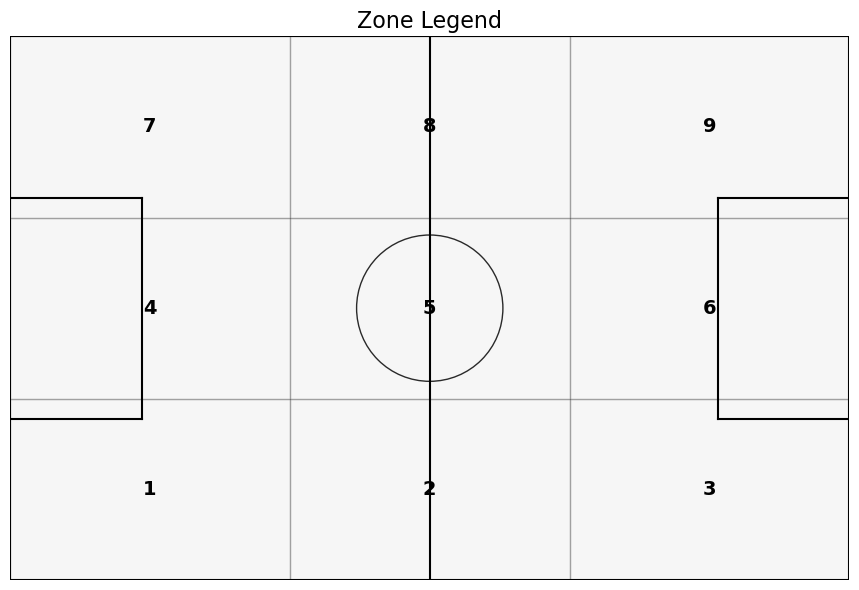

In [77]:
import matplotlib.patches as patches

# Define edges matching your pitch grid
x_edges = np.linspace(-52.5, 52.5, 4)
y_edges = np.linspace(-34, 34, 4)

fig, ax = plt.subplots(figsize=(10, 6))

# Draw pitch outline
draw_pitch(ax)

zone_idx = 1

# Draw zone rectangles and labels
for y_bin in range(3):
    for x_bin in range(3):
        x_left = x_edges[x_bin]
        x_right = x_edges[x_bin + 1]
        y_bottom = y_edges[y_bin]
        y_top = y_edges[y_bin + 1]

        width = x_right - x_left
        height = y_top - y_bottom

        rect = patches.Rectangle(
            (x_left, y_bottom),
            width,
            height,
            linewidth=1,
            edgecolor='black',
            facecolor='lightgrey',
            alpha=0.2
        )
        ax.add_patch(rect)

        # Label in center
        x_center = (x_left + x_right) / 2
        y_center = (y_bottom + y_top) / 2

        ax.text(
            x_center, y_center,
            str(zone_idx),
            ha='center',
            va='center',
            fontsize=14,
            fontweight='bold',
            color='black'
        )

        zone_idx += 1

ax.set_title("Zone Legend", fontsize=16)
plt.tight_layout()
plt.show()

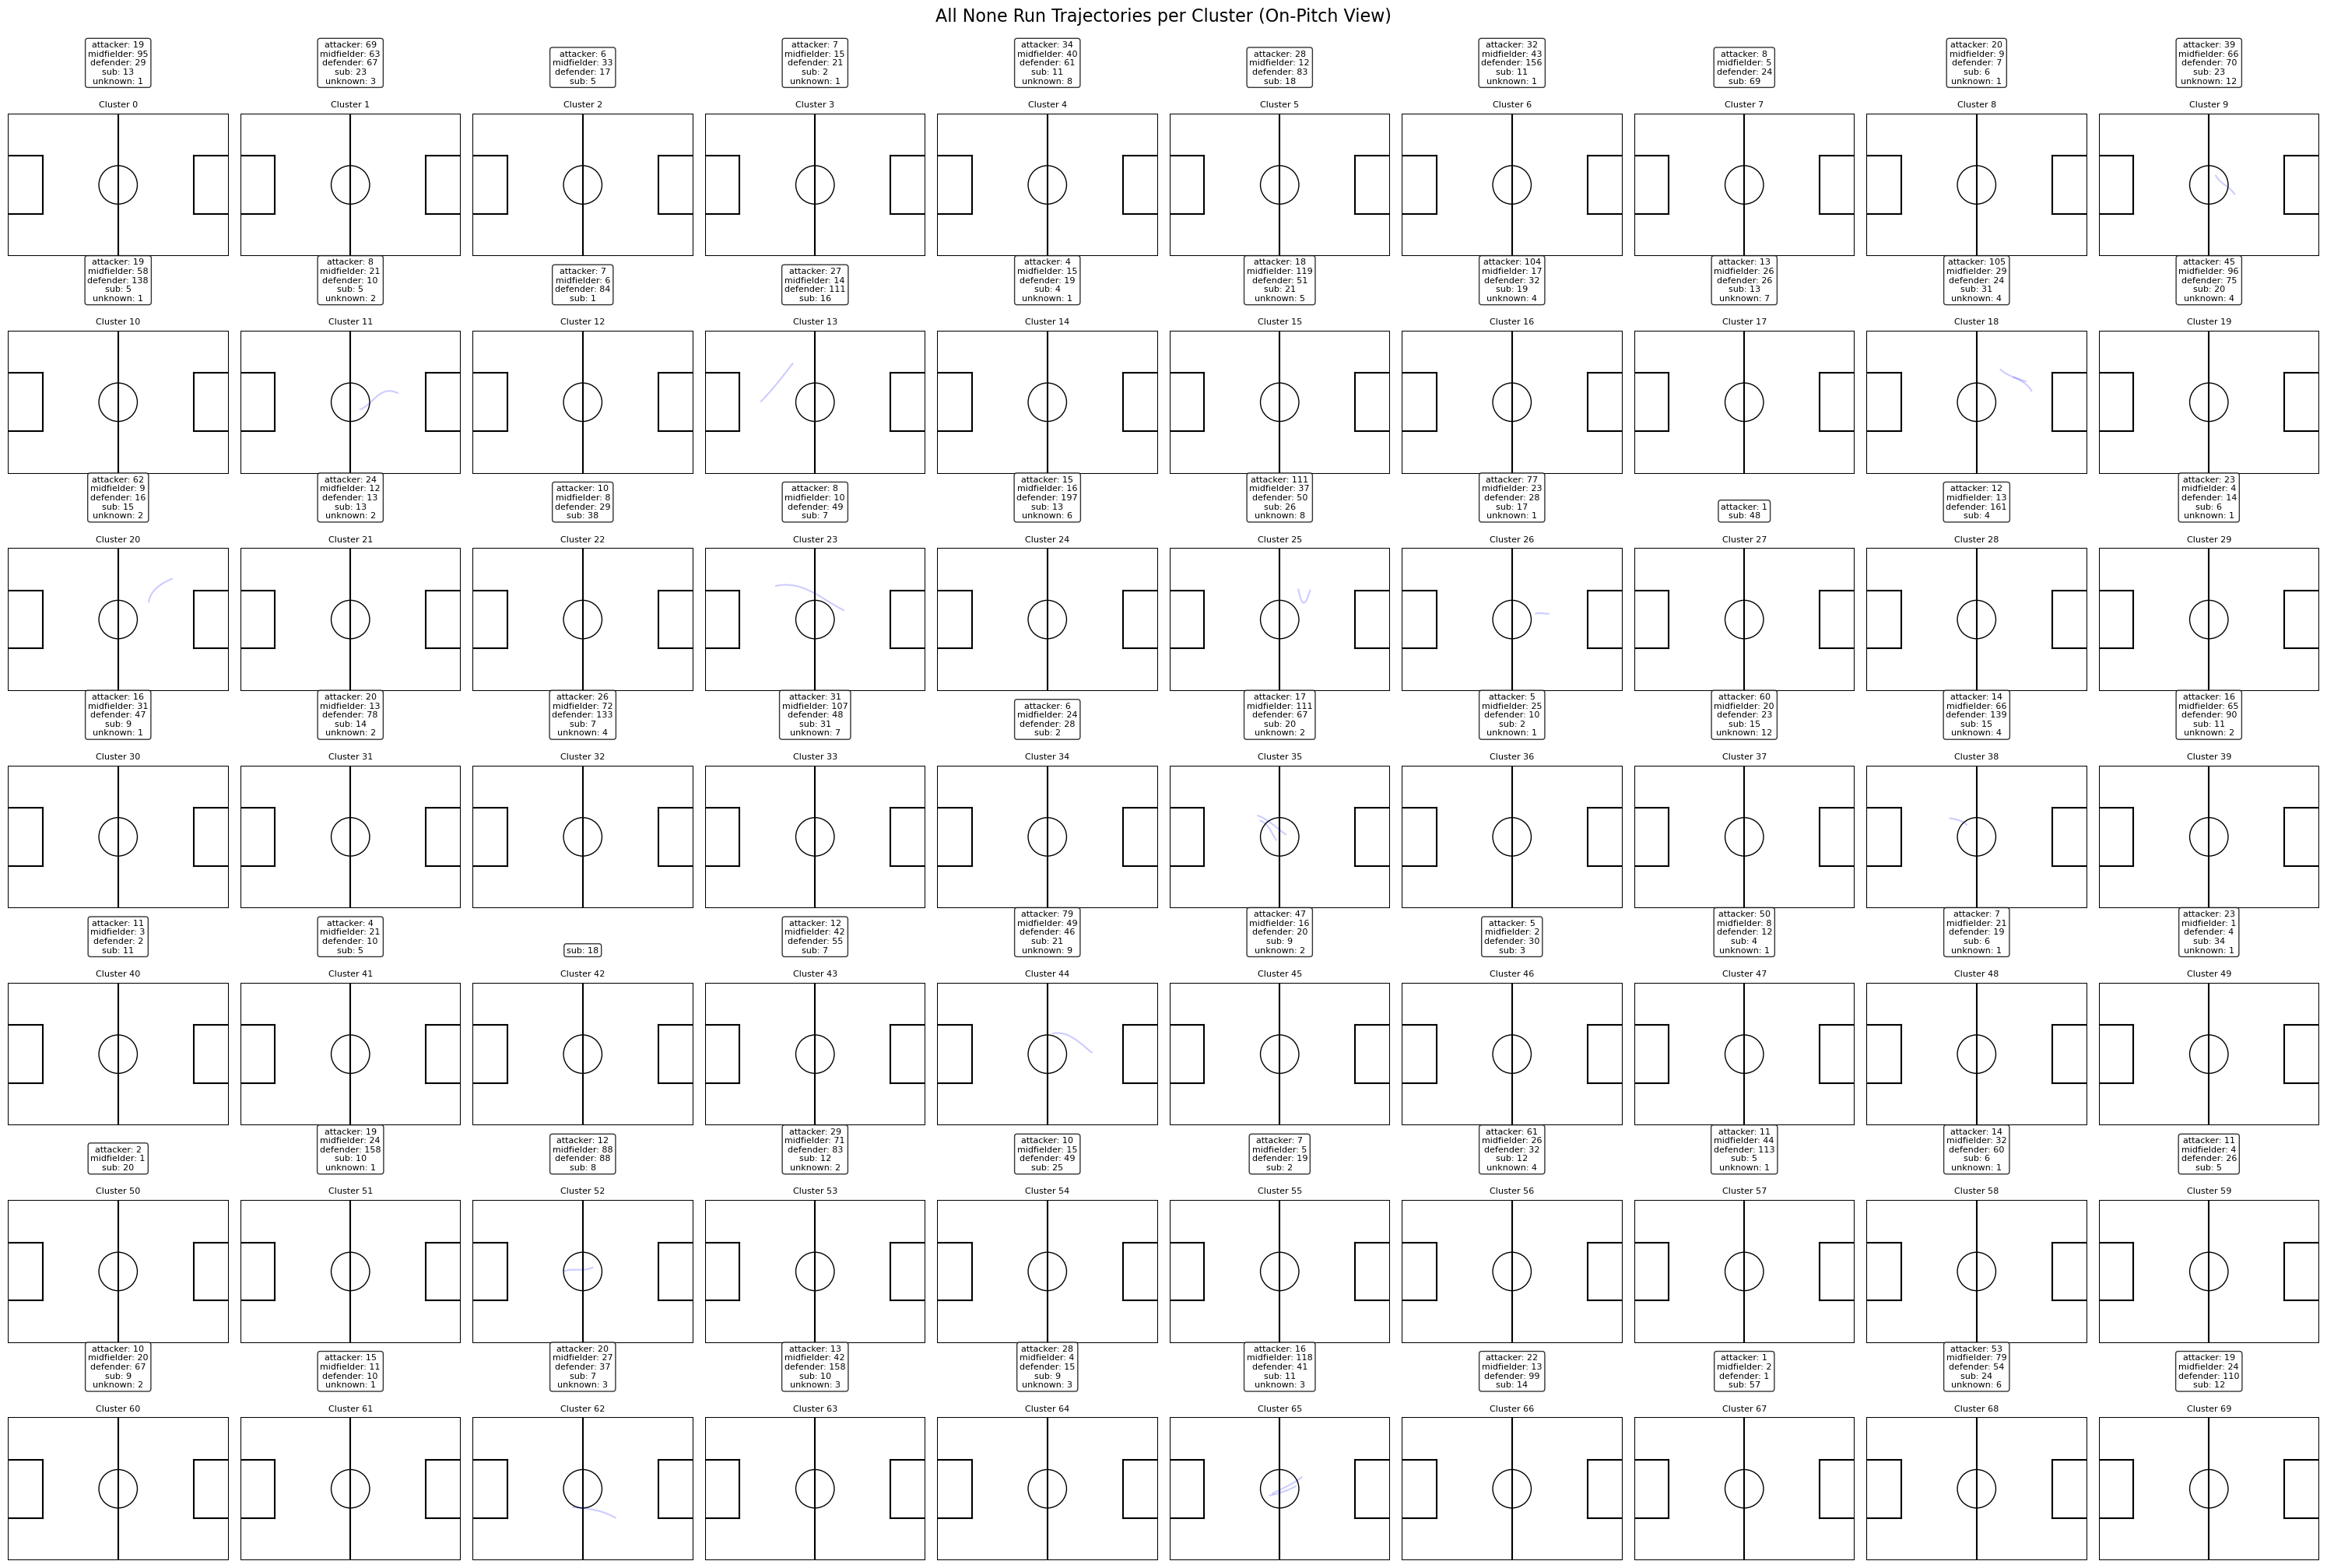

In [78]:
plot_all_cluster_trajectories_on_pitch(
    final_runs_df,
    assignments_zones,
    cluster_control_points,
    bucket_pivot=bucket_pivot,
    num_control_points=4,
    max_runs_per_cluster=200,
    plot_absolute_positions=False,
    start_zones=None,
    end_zones=None,  # You can specify zones like [1, 2, 3] if you want to filter
    phases_of_play=None,
    positions=None,
    use_absolute_zones=False, # True or False are options
    start_zones_absolute=None,
    end_zones_absolute=None,
    run_angle_range=None,  # Example: filter for runs with angles between 0 and 180 degrees
    run_forward=None,
    run_length_range = None,  # Example: filter for runs with length between 0 and 100 meters
    mean_speed_range = None,  # Example: filter for runs with mean speed between 0 and 8 m/s
    max_speed_range = None,
    tactical_overlap=True,
    tactical_underlap=None,
    tactical_diagonal=None,
    runner_received_pass=None     
)



In [ ]:
# plot_all_cluster_trajectories_on_pitch(
#     final_runs_df=final_runs_df,
#     assignments_zones=assignments_zones_bezier,
#     cluster_control_points=cluster_control_points,
#     bucket_pivot=bezier_bucket_pivot,
#     num_control_points=4,
#     max_runs_per_cluster=200,
#     title="Bézier+L1",
#     is_autoencoder=False,  # <- use Bézier evaluation logic
#     plot_absolute_positions=False,
#     start_zones=None,
#     end_zones=None,  # You can specify zones like [1, 2, 3] if you want to filter
#     phases_of_play=None,
#     positions=None,
#     use_absolute_zones=False, # True or False are options
#     start_zones_absolute=None,
#     end_zones_absolute=None,
#     run_angle_range=None,  # Example: filter for runs with angles between 0 and 180 degrees
#     run_forward=None,
#     run_length_range = None,  # Example: filter for runs with length between 0 and 100 meters
#     mean_speed_range = None,  # Example: filter for runs with mean speed between 0 and 8 m/s
#     max_speed_range = None,
#     tactical_overlap=True,
#     tactical_underlap=None,
#     tactical_diagonal=None,
#     runner_received_pass=None  
# )

# plot_all_cluster_trajectories_on_pitch(
#     final_runs_df=final_runs_df,
#     assignments_zones=assignments_zones_ae,
#     cluster_control_points=cluster_control_points_ae,
#     bucket_pivot=ae_bucket_pivot,
#     is_autoencoder=True,
#     num_control_points=4,  # Still passed, but unused
#     max_runs_per_cluster=200,
#     title="Autoencoder",  # <- use Bézier evaluation logic
#     plot_absolute_positions=False,
#     start_zones=None,
#     end_zones=None,  # You can specify zones like [1, 2, 3] if you want to filter
#     phases_of_play=None,
#     positions=None,
#     use_absolute_zones=False, # True or False are options
#     start_zones_absolute=None,
#     end_zones_absolute=None,
#     run_angle_range=None,  # Example: filter for runs with angles between 0 and 180 degrees
#     run_forward=None,
#     run_length_range = None,  # Example: filter for runs with length between 0 and 100 meters
#     mean_speed_range = None,  # Example: filter for runs with mean speed between 0 and 8 m/s
#     max_speed_range = None,
#     tactical_overlap=None,
#     tactical_underlap=None,
#     tactical_diagonal=None,
#     runner_received_pass=None  
# )

# Metrics


In [79]:

def compute_reconstruction_loss(model, data_tensor):
    model.eval()
    with torch.no_grad():
        recon, _ = model(data_tensor.to(next(model.parameters()).device))
    mse = mean_squared_error(
        data_tensor.cpu().numpy().reshape(len(data_tensor), -1),
        recon.cpu().numpy().reshape(len(data_tensor), -1)
    )
    return mse

recon_loss = compute_reconstruction_loss(model, traj_tensor)
print(f"Autoencoder Reconstruction Loss: {recon_loss:.4f}")

Autoencoder Reconstruction Loss: 0.0566


In [80]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.metrics import mean_squared_error

def evaluate_clustering_metrics(features, labels, name=""):
    sil = silhouette_score(features, labels)
    dbi = davies_bouldin_score(features, labels)
    print(f"{name} Silhouette Score: {sil:.4f}")
    print(f"{name} Davies-Bouldin Index: {dbi:.4f}")
    return sil, dbi

# Autoencoder
autoencoder_assignments_df = pd.DataFrame(autoencoder_assignments)
evaluate_clustering_metrics(all_z, autoencoder_assignments_df["ae_cluster"], name="Autoencoder")




# Bézier (make sure you're using per-run control points, not cluster centers!)

run_trajs = np.stack(assignments_df["resampled_traj"].to_numpy())  # shape (N, 50, 2)
run_trajs_flat = run_trajs.reshape(len(run_trajs), -1)

# Cluster labels
labels = assignments_df["assigned_cluster"]

evaluate_clustering_metrics(run_trajs_flat, labels, name="Bézier")


Autoencoder Silhouette Score: 0.1978
Autoencoder Davies-Bouldin Index: 1.2150
Bézier Silhouette Score: 0.1805
Bézier Davies-Bouldin Index: 1.2506


(0.18050144598753276, 1.2506232305476046)

In [ ]:
print(autoencoder_assignments[0:4])

[{'run_id': 0, 'ae_cluster': 22, 'playerId': '037320d1-4b80-4301-bbb6-1fa4a1669f25', 'player_name': 'Gabriel Martinelli', 'position': 'LW', 'team_role': 'away', 'match_id': 'tracking_g2292810'}, {'run_id': 1, 'ae_cluster': 22, 'playerId': '037320d1-4b80-4301-bbb6-1fa4a1669f25', 'player_name': 'Gabriel Martinelli', 'position': 'LW', 'team_role': 'away', 'match_id': 'tracking_g2292810'}, {'run_id': 2, 'ae_cluster': 54, 'playerId': '037320d1-4b80-4301-bbb6-1fa4a1669f25', 'player_name': 'Gabriel Martinelli', 'position': 'LW', 'team_role': 'away', 'match_id': 'tracking_g2292810'}, {'run_id': 3, 'ae_cluster': 58, 'playerId': '037320d1-4b80-4301-bbb6-1fa4a1669f25', 'player_name': 'Gabriel Martinelli', 'position': 'LW', 'team_role': 'away', 'match_id': 'tracking_g2292810'}]


# RL: OBV

In [ ]:
# ------------------------------------------------------------------------
# STEP 1 — ensure seconds_period in final_runs_df
# ------------------------------------------------------------------------

def ensure_seconds_period(final_runs_df, frames_df):
    """
    Ensures seconds_period is present in final_runs_df.
    """
    frames_df["seconds_period"] = 45*60 - frames_df["gameClock"]

    if "seconds_period" not in final_runs_df.columns:
        final_runs_df = final_runs_df.merge(
            frames_df[["match_id", "period", "frameIdx", "seconds_period"]],
            on=["match_id", "period", "frameIdx"],
            how="left",
        )
    return final_runs_df

final_runs_df = ensure_seconds_period(final_runs_df, frames_df)

# ------------------------------------------------------------------------
# STEP 2 — extract OBV value
# ------------------------------------------------------------------------

def extract_obv_value(event_row, obv_column="obv_total_net"):
    """
    Extract OBV value directly from top-level column.
    """
    val = event_row.get(obv_column, 0.0)
    if val is None or pd.isna(val):
        return 0.0
    return val

# ------------------------------------------------------------------------
# STEP 3 — compute OBV delta for a single run
# ------------------------------------------------------------------------

def compute_obv_delta_for_run(run_df, events_df, obv_column="obv_total_net", lookahead_seconds=30.0):
    """
    Compute OBV reward for a single run:
        OBV(after the run) - OBV(before the run)
    """
    match_id = run_df["match_id"].iloc[0]
    period = run_df["period"].iloc[0]

    run_start_time = run_df["seconds_period"].min()
    run_end_time = run_df["seconds_period"].max()

    # Filter events for same period
    events_period = events_df[events_df["period"] == period]

    # Last event before the run
    before_events = events_period[
        events_period["seconds_period"] < run_start_time
    ]

    if not before_events.empty:
        last_before = before_events.iloc[-1]
        obv_before = extract_obv_value(last_before, obv_column)
    else:
        obv_before = 0.0

    # First event after the run
    after_events = events_period[
        (events_period["seconds_period"] > run_end_time) &
        (events_period["seconds_period"] <= run_end_time + lookahead_seconds)
    ]

    if not after_events.empty:
        first_after = after_events.iloc[0]
        obv_after = extract_obv_value(first_after, obv_column)
    else:
        obv_after = obv_before

    delta_obv = obv_after - obv_before
    return delta_obv

# ------------------------------------------------------------------------
# STEP 4 — assign OBV rewards to all runs
# ------------------------------------------------------------------------

def assign_obv_rewards_to_runs(final_runs_df, events_dfs_by_match, lookahead_seconds=30.0):
    """
    Compute OBV delta rewards for all runs.
    
    Returns:
        DataFrame with columns: run_id, reward
    """
    run_rewards = []

    grouped_runs = final_runs_df.groupby("run_id")

    for run_id, run_df in grouped_runs:
        match_id = run_df["match_id"].iloc[0]

        # Clean the match ID like your test code does:
        match_id_clean = match_id.replace(".json", "")

        events_df = events_dfs_by_match.get(match_id_clean)

        if events_df is None:
            reward = 0.0
        else:
            reward = compute_obv_delta_for_run(
                run_df,
                events_df,
                obv_column="obv_total_net",
                lookahead_seconds=lookahead_seconds,
            )

        run_rewards.append({
            "run_id": run_id,
            "reward": reward
        })

    return pd.DataFrame(run_rewards)

# ------------------------------------------------------------------------
# STEP 5 — run the pipeline
# ------------------------------------------------------------------------

run_rewards_df = assign_obv_rewards_to_runs(
    final_runs_df,
    events_dfs_by_match,
    lookahead_seconds=30.0
)

# OPTIONAL: show histogram
import matplotlib.pyplot as plt

plt.hist(run_rewards_df["reward"], bins=50)
plt.title("Histogram of OBV Rewards for Runs")
plt.xlabel("Reward (Δ OBV)")
plt.ylabel("Frequency")
plt.show()

# Merge with assignments
reward_assignments_df = assignments_df.merge(
    run_rewards_df,
    on="run_id",
    how="left"
)

reward_assignments_df["reward"].fillna(0.0, inplace=True)

print(run_rewards_df.head())

In [ ]:
# ------------------------------------------------------------
# STEP 6 — build run-centric features
# ------------------------------------------------------------

# def compute_run_features(final_runs_df):
#     """
#     For each run_id, compute geometric features for pure run regression.
#     """
#     run_feature_rows = []
    
#     grouped = final_runs_df.groupby("run_id")
    
#     for run_id, run_df in grouped:
#         match_id = run_df["match_id"].iloc[0]
#         period = run_df["period"].iloc[0]
        
#         # Get start & end locations
#         x_start = run_df["x"].iloc[0]
#         y_start = run_df["y"].iloc[0]
#         x_end = run_df["x"].iloc[-1]
#         y_end = run_df["y"].iloc[-1]
        
#         dx = x_end - x_start
#         dy = y_end - y_start
#         length = np.hypot(dx, dy)
        
#         # Angle in radians (0 = rightward, π/2 = upward)
#         angle = np.arctan2(dy, dx)
        
#         # Duration
#         duration = run_df["seconds_period"].max() - run_df["seconds_period"].min()
        
#         # Average speed
#         avg_speed = run_df["speed"].mean()
        
#         run_feature_rows.append({
#             "run_id": run_id,
#             "match_id": match_id,
#             "period": period,
#             "x_start": x_start,
#             "y_start": y_start,
#             "x_end": x_end,
#             "y_end": y_end,
#             "length": length,
#             "angle": angle,
#             "duration": duration,
#             "avg_speed": avg_speed
#         })
        
#     return pd.DataFrame(run_feature_rows)

# run_features_df = compute_run_features(final_runs_df)
# print(run_features_df.head())

In [ ]:
# ------------------------------------------------------------
# STEP 7 — build state vectors for contextual bandit
# ------------------------------------------------------------

# def create_state_vectors(final_runs_df, players_df, frames_df):
#     """
#     For each run, extract the full player and ball context
#     at the first frame of the run.
#     """
#     state_rows = []
    
#     for run_id, run_df in final_runs_df.groupby("run_id"):
#         match_id = run_df["match_id"].iloc[0]
#         period = run_df["period"].iloc[0]
#         start_frame = run_df["frameIdx"].min()

#         # Player positions
#         players_at_start = players_df[
#             (players_df["match_id"] == match_id) &
#             (players_df["period"] == period) &
#             (players_df["frameIdx"] == start_frame)
#         ]

#         player_coords = []
#         for _, p in players_at_start.iterrows():
#             player_coords.extend([p["x"], p["y"]])
        
#         # Check how many players we found
#         if len(player_coords) < 22 * 2:
#             # Skip this run
#             continue
        
#         # Ball position
#         ball_at_start = frames_df[
#             (frames_df["match_id"] == match_id) &
#             (frames_df["period"] == period) &
#             (frames_df["frameIdx"] == start_frame)
#         ]
        
#         if ball_at_start.empty:
#             continue
        
#         ball_x = ball_at_start["ball_x"].iloc[0]
#         ball_y = ball_at_start["ball_y"].iloc[0]
        
#         # Build state vector
#         state_vector = np.array(player_coords + [ball_x, ball_y])
        
#         state_rows.append({
#             "run_id": run_id,
#             "state_vector": state_vector
#         })
    
#     return pd.DataFrame(state_rows)

# states_df = create_state_vectors(final_runs_df, players_df, frames_df)
# print(states_df.head())

In [ ]:
# --------------------------------------------------------------------------------
# C-OBSO REWARD FUNCTION
# --------------------------------------------------------------------------------

def compute_transition_field(state_row, grid_size=5.0, sigma=14.0):
    """
    P(T_r | D): Gaussian centered on ball position → where next on-ball event occurs.
    """
    ball_x, ball_y = state_row["ball_coords"]
    xs = np.arange(0, 105 + grid_size, grid_size)
    ys = np.arange(0, 68  + grid_size, grid_size)
    X, Y = np.meshgrid(xs, ys, indexing="ij")
    pos = np.dstack([X, Y])
    rv = multivariate_normal(mean=[ball_x, ball_y],
                             cov=[[sigma**2, 0], [0, sigma**2]])
    return rv.pdf(pos)  # shape (nx, ny)


def compute_PPCF(players_df, match_id, period, frameIdx,
                 lambdas=None, s=0.45, grid_size=5.0):
    """
    P(C_r | D): Potential Pitch Control Field (PPCF).
    We discretize and integrate the Poisson‐arrival model.
    For simplicity we approximate final control probability at T→∞:
       P_control(r) = 1 - exp( - λ_j * f_j(r) )  summed over j
    where f_j(r) = sigmoid( (T_exp - T)/sqrt(3 s / π) ), approximated here by
    a logistic of distance to r.
    """
    # load the 22 players at that frame
    frame = players_df.query(
        "match_id==@match_id & period==@period & frameIdx==@frameIdx"
    ).reset_index(drop=True)
    coords = frame[["x","y"]].values  # (22,2)
    # default λ_j = same for all
    if lambdas is None:
        lambdas = np.ones(len(coords)) * 4.3

    xs = np.arange(0, 105 + grid_size, grid_size)
    ys = np.arange(0, 68  + grid_size, grid_size)
    PPCF = np.zeros((len(xs), len(ys)))

    for i, x in enumerate(xs):
        for j, y in enumerate(ys):
            dists = np.linalg.norm(coords - np.array([x, y]), axis=1)
            # expected intercept time T_exp ∝ dist / avg_speed (≈5m/s)
            Texp = dists / 5.0
            # logistic f_j
            f_j = 1.0 / (1.0 + np.exp(-(Texp - Texp) / np.sqrt(3*s/np.pi)))
            # per‐player asymptotic control: 1 - exp(-λ_j * f_j)
            p_control = 1 - np.exp(-lambdas * f_j)
            # assuming independence, team control = 1 - ∏(1 - p_j)
            PPCF[i,j] = 1 - np.prod(1 - p_control)
    return PPCF


def compute_shot_field(players_df, frames_df,
                       match_id, period, frameIdx,
                       grid_size=5.0, C=1.0, c=0.2):
    """
    P(S_r | D): shot success probability from each grid cell,
    adjusted by defenders' shot‐blocking distribution.
    """
    # load defenders and their positions
    frame = players_df.query(
        "match_id==@match_id & period==@period & frameIdx==@frameIdx"
    ).reset_index(drop=True)
    coords = frame[["x","y"]].values
    sides  = frame["side"].values  # "home" or "away"
    # determine attacking side
    last = frames_df.query(
        "match_id==@match_id & period==@period & frameIdx==@frameIdx"
    )["lastTouch_team"].iat[0]
    attack_mask = (sides == last)

    xs = np.arange(0, 105 + grid_size, grid_size)
    ys = np.arange(0, 68  + grid_size, grid_size)
    SF = np.zeros((len(xs), len(ys)))

    # goal is at (105, 34)
    goal = np.array([105.0, 34.0])
    #CHECK IF THESE COORDS ARE CORRECT ACCORDING TO TRACKING FILES

    for i, x in enumerate(xs):
        for j, y in enumerate(ys):
            r = np.array([x, y])
            # generate shot vectors: here just one direct vector
            vec = goal - r
            # defenders on attack side
            def_idxs = np.where(~attack_mask)[0]
            # compute block value: sum of Gaussians along that vector
            V_block = 0
            for d in def_idxs:
                dpos = coords[d]
                # project defender onto line ‖vec‖
                t = np.dot(dpos - r, vec) / np.dot(vec, vec)
                proj = r + t * vec
                # distance from line
                perp = np.linalg.norm(dpos - proj)
                sigma2 = 0.5 + np.linalg.norm(r - dpos)
                V_block += multivariate_normal.pdf(
                    [perp, 0], mean=[0,0], cov=[[sigma2,0],[0,sigma2]]
                )
            V_shot = max(0.0, C*(c - V_block))
            SF[i,j] = V_shot

    # normalize to [0,1]
    SF = SF / (SF.max() + 1e-8)
    return SF


def compute_OBSO(state_row, players_df, frames_df,
                 grid_size=5.0, sigma=14.0):
    """
    Full OBSO value:
      V_OBSO = Σ_r P(T_r) · P(C_r) · P(S_r)
    """
    # 1) transition
    T = compute_transition_field(state_row, grid_size, sigma)
    # 2) control
    # we need match_id,period,frameIdx from state_row:
    m, p, f = state_row["match_id"], state_row["period"], state_row["frameIdx"]
    C = compute_PPCF(players_df, m, p, f, grid_size=grid_size)
    # 3) shot
    S = compute_shot_field(players_df, frames_df, m, p, f, grid_size=grid_size)
    # combine
    return np.sum(T * C * S) * (grid_size**2)

def c_obso_reward_fn(run_df, players_df, frames_df):
    """
    Computes C-OBSO reward for the run.

    Parameters
    ----------
    run_df : pd.DataFrame
        DataFrame with the trajectory of a single run.

    players_df : pd.DataFrame
        Players tracking data.

    frames_df : pd.DataFrame
        Frames tracking data.

    Returns
    -------
    float
        C-OBSO value for this run.
    """
    end_row = run_df.iloc[-1]
    match_id = end_row["match_id"]
    period = end_row["period"]
    frameIdx = end_row["frameIdx"]

    # Extract state for the end frame
    # This matches your class logic:
    state_row = {
        "match_id": match_id,
        "period": period,
        "frameIdx": frameIdx
    }

    # Add ball coords:
    ball_at_frame = frames_df[
        (frames_df["match_id"] == match_id) &
        (frames_df["period"] == period) &
        (frames_df["frameIdx"] == frameIdx)
    ]
    if ball_at_frame.empty:
        return 0.0

    ball_x = ball_at_frame["ball_x"].iloc[0]
    ball_y = ball_at_frame["ball_y"].iloc[0]
    state_row["ball_coords"] = np.array([ball_x, ball_y])

    return compute_OBSO(
        state_row,
        players_df,
        frames_df
    )





In [ ]:
class DQNNetwork(nn.Module):
    def __init__(self, state_dim, action_space_size, hidden_size=256):
        super().__init__()
        input_dim = state_dim + action_space_size
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, state_action_batch):
        return self.net(state_action_batch).squeeze(-1)
    
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_space_size, hidden_size=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_space_size)
        )
    
    def forward(self, state_batch):
        return self.net(state_batch)
    
class ActorNetwork(nn.Module):
    def __init__(self, state_dim, action_space_size, hidden_size=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_space_size)
        )
    
    def forward(self, state_batch):
        logits = self.net(state_batch)
        return torch.softmax(logits, dim=-1)

class CriticNetwork(nn.Module):
    def __init__(self, state_dim, hidden_size=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, state_batch):
        return self.net(state_batch).squeeze(-1)
    
class GVRNN(nn.Module):
    def __init__(
        self,
        state_dim,
        action_space_size,
        latent_dim=16,
        hidden_dim=128,
        future_steps=20
    ):
        super().__init__()
        self.state_dim = state_dim
        self.action_space_size = action_space_size
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.future_steps = future_steps

        # Action embedding
        self.action_emb = nn.Embedding(action_space_size, hidden_dim)

        # Encoder: q(z_t | x_t, h_t-1)
        self.encoder = nn.Sequential(
            nn.Linear(state_dim + hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2 * latent_dim)
        )

        # Prior: p(z_t | h_t-1)
        self.prior = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2 * latent_dim)
        )

        # Decoder: p(x_t | z_t, h_t-1)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, state_dim)  # predict future state
        )

        # RNN to track history
        self.rnn = nn.GRU(state_dim + latent_dim, hidden_dim)

    def forward(self, past_seq, action_idx):
        """
        Forward pass for training.

        past_seq: (T_past, batch, state_dim)
        action_idx: (batch,) int cluster indices
        """

        batch_size = past_seq.shape[1]
        action_emb = self.action_emb(action_idx)   # (batch, hidden_dim)

        h = action_emb.unsqueeze(0)  # (1, batch, hidden_dim)

        zs = []
        mus_post = []
        logvars_post = []
        recons = []

        for t in range(past_seq.shape[0]):
            x_t = past_seq[t]

            # Prior
            prior_out = self.prior(h.squeeze(0))
            mu_prior, logvar_prior = torch.chunk(prior_out, 2, dim=-1)
            logvar_prior = torch.clamp(logvar_prior, min=-10.0, max=10.0)

            # Encoder q(z|x,h)
            encoder_in = torch.cat([x_t, h.squeeze(0)], dim=-1)
            enc_out = self.encoder(encoder_in)
            mu_post, logvar_post = torch.chunk(enc_out, 2, dim=-1)
            logvar_post = torch.clamp(logvar_post, min=-10.0, max=10.0)

            z_t = self.reparameterize(mu_post, logvar_post)
            zs.append(z_t)
            mus_post.append(mu_post)
            logvars_post.append(logvar_post)

            # Decoder
            decoder_in = torch.cat([z_t, h.squeeze(0)], dim=-1)
            x_hat = self.decoder(decoder_in)
            recons.append(x_hat)

            # RNN step
            rnn_in = torch.cat([x_t, z_t], dim=-1).unsqueeze(0)
            _, h = self.rnn(rnn_in, h)

        return recons, mus_post, logvars_post

    def sample(self, past_seq, action_idx, num_samples=10):
        """
        Generate samples of future sequences.
        """
        batch_size = past_seq.shape[1]
        action_emb = self.action_emb(action_idx)
        h = action_emb.unsqueeze(0)

        samples = []

        for n in range(num_samples):
            traj = []
            h_t = h

            for t in range(self.future_steps):
                # Prior p(z | h)
                prior_out = self.prior(h_t.squeeze(0))
                mu_prior, logvar_prior = torch.chunk(prior_out, 2, dim=-1)
                logvar_prior = torch.clamp(logvar_prior, min=-10.0, max=10.0)

                z_t = self.reparameterize(mu_prior, logvar_prior)

                decoder_in = torch.cat([z_t, h_t.squeeze(0)], dim=-1)
                x_hat = self.decoder(decoder_in)

                traj.append(x_hat)

                # RNN step
                rnn_in = torch.cat([x_hat, z_t], dim=-1).unsqueeze(0)
                _, h_t = self.rnn(rnn_in, h_t)

            traj = torch.stack(traj, dim=0)
            samples.append(traj)

        return samples

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    

class TrackingDataset(Dataset):
    """
    Dataset of:
       past_seq: (T_past, state_dim)
       future_seq: (T_future, state_dim)
       action_idx: int
    """
    def __init__(self, data_tuples):
        self.data = data_tuples

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
# KL Divergence Function
    
def kl_divergence(mu_q, logvar_q, mu_p, logvar_p):
    """
    KL between N(mu_q, sigma_q) || N(mu_p, sigma_p)
    """
    return 0.5 * torch.sum(
        logvar_p - logvar_q
        + (torch.exp(logvar_q) + (mu_q - mu_p) ** 2) / torch.exp(logvar_p)
        - 1,
        dim=-1
    )
    
# -----------------------
# Training function
# -----------------------

def train_gvrnn(
    gvrnn_model,
    dataset,
    num_epochs=50,
    batch_size=64,
    lr=1e-3,
    device="cuda" if torch.cuda.is_available() else "cpu"
):
    gvrnn_model = gvrnn_model.to(device)
    optimizer = torch.optim.Adam(gvrnn_model.parameters(), lr=lr)

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
        total_loss = 0.0
        total_rec_loss = 0.0
        total_kl = 0.0

        for past_seq, future_seq, action_idx in loader:
            past_seq = past_seq.to(device)         # (T_past, B, state_dim)
            future_seq = future_seq.to(device)     # (T_future, B, state_dim)
            action_idx = action_idx.to(device)     # (B,)

            past_seq = past_seq.transpose(0, 1)    # → (T_past, B, state_dim)
            future_seq = future_seq.transpose(0, 1)

            # Forward pass over past seq
            recons, mus_post, logvars_post = gvrnn_model(past_seq, action_idx)

            # Prior terms
            h = gvrnn_model.action_emb(action_idx).unsqueeze(0)  # (1, B, H)
            kl_total = 0.0

            rec_loss = 0.0
            for t, (x_hat, mu_post, logvar_post) in enumerate(zip(recons, mus_post, logvars_post)):
                # Ground truth for past
                x_true = past_seq[t]

                # Prior for timestep t
                prior_out = gvrnn_model.prior(h.squeeze(0))
                mu_prior, logvar_prior = torch.chunk(prior_out, 2, dim=-1)

                # KL divergence
                kl = kl_divergence(mu_post, logvar_post, mu_prior, logvar_prior)
                kl_total += kl.mean()

                # Reconstruction loss
                rec_loss += torch.mean((x_hat - x_true) ** 2)

                # Update RNN hidden state
                z_t = gvrnn_model.reparameterize(mu_post, logvar_post)
                rnn_in = torch.cat([x_true, z_t], dim=-1).unsqueeze(0)
                _, h = gvrnn_model.rnn(rnn_in, h)

            # Mean over timesteps
            rec_loss = rec_loss / len(recons)

            loss = rec_loss + kl_total * 0.1  # weight KL if desired

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_rec_loss += rec_loss.item()
            total_kl += kl_total.item()

        avg_loss = total_loss / len(loader)
        avg_rec = total_rec_loss / len(loader)
        avg_kl = total_kl / len(loader)
        print(f"Epoch {epoch+1:3d}: Loss={avg_loss:.4f}, Recon={avg_rec:.4f}, KL={avg_kl:.4f}")

def build_tracking_dataset(
    runs_df,
    assignments_df,
    players_df,
    frames_df,
    model,
    T_past=10,
    T_future=10
):
    dataset = []

    for run_id, run_df in tqdm(runs_df.groupby("run_id"), desc="Building tracking dataset", total=runs_df["run_id"].nunique()):
        if len(run_df) < 4:
            continue

        match_id = run_df["match_id"].iloc[0]
        period = run_df["period"].iloc[0]
        action = run_df["assigned_cluster"].iloc[0]

        # split into past and future
        split_idx = int(len(run_df) * 0.5)
        if split_idx < 1:
            continue

        past_df = run_df.iloc[:split_idx]
        future_df = run_df.iloc[split_idx:]

        if past_df.empty or future_df.empty:
            continue

        # get state rows for each frame
        past_states = []
        for f in past_df["frameIdx"]:
            state_row = model._extract_frame_state(match_id, period, f, players_df, frames_df)
            if state_row is None:
                continue
            past_states.append(model.state_fn(state_row))
        if len(past_states) == 0:
            continue

        # pad/truncate
        past_states = np.stack(past_states, axis=0)
        if past_states.shape[0] < T_past:
            pad_len = T_past - past_states.shape[0]
            pad = np.zeros((pad_len, past_states.shape[1]))
            past_states = np.concatenate([past_states, pad], axis=0)
        else:
            past_states = past_states[:T_past]

        future_states = []
        for f in future_df["frameIdx"]:
            state_row = model._extract_frame_state(match_id, period, f, players_df, frames_df)
            if state_row is None:
                continue
            future_states.append(model.state_fn(state_row))
        if len(future_states) == 0:
            continue

        future_states = np.stack(future_states, axis=0)
        if future_states.shape[0] < T_future:
            pad_len = T_future - future_states.shape[0]
            pad = np.zeros((pad_len, future_states.shape[1]))
            future_states = np.concatenate([future_states, pad], axis=0)
        else:
            future_states = future_states[:T_future]

        dataset.append((
            torch.tensor(past_states, dtype=torch.float32),
            torch.tensor(future_states, dtype=torch.float32),
            torch.tensor(action, dtype=torch.long)
        ))

    print(f"Built GVRNN dataset with {len(dataset)} sequences.")
    return TrackingDataset(dataset)


In [ ]:

class FootballOffBallRL(BaseEstimator):
    """
    RL pipeline for off-ball runs in football.
    
    This class:
    - stores state/action/reward/next-state data
    - fits an RL model (e.g. fitted Q iteration)
    - ranks players by long-term run value
    
    Customisable:
    - State feature extraction
    - Reward functions
    - Learning algorithms
    """

    def __init__(
        self,
        method="lightgbm",        # "lightgbm" or "dqn" or "actor-critic"
        gamma=0.9,
        n_iters=10,
        action_space_size=70,
        regressor=None,           # Used only for LightGBM
        state_fn=None,
        reward_fn=None,
        # DQN specific:
        state_dim=None,
        hidden_size=256,
        batch_size=128,
        learning_rate=1e-3,
        device="cpu",
        target_update_freq=1000,  # How often to update target network
        reward_func="obv",
        gvrnn_model=None,         # Optional GVRNN model for future prediction
    ):
        self.method = method
        self.gamma = gamma
        self.n_iters = n_iters
        self.action_space_size = action_space_size
        self.state_fn = state_fn
        self.reward_fn = reward_fn
        self.target_update_freq = target_update_freq
        self.reward_func = reward_func
        self.gvrnn_model = gvrnn_model

        if method == "lightgbm":
            self.regressor = regressor if regressor is not None else LGBMRegressor()
        elif method == "dqn":
            assert state_dim is not None, "state_dim required for DQN"
            self.q_network = QNetwork(
                state_dim=state_dim,
                action_space_size=action_space_size,
                hidden_size=hidden_size
            ).to(device)

            # NEW: Target network
            self.target_q_network = QNetwork(
                state_dim=state_dim,
                action_space_size=action_space_size,
                hidden_size=hidden_size
            ).to(device)

            # Initially identical
            self.target_q_network.load_state_dict(self.q_network.state_dict())
            self.target_q_network.eval()

            self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)
            self.loss_fn = nn.MSELoss()
            self.device = device
            self.batch_size = batch_size
            self.target_update_freq = target_update_freq or 1000

        elif method == "actor_critic":
            assert state_dim is not None, "state_dim required for Actor-Critic"
            
            self.actor = ActorNetwork(
                state_dim=state_dim,
                action_space_size=action_space_size,
                hidden_size=hidden_size
            ).to(device)

            self.critic = CriticNetwork(
                state_dim=state_dim,
                hidden_size=hidden_size
            ).to(device)

            self.optimizer_actor = optim.Adam(self.actor.parameters(), lr=learning_rate)
            self.optimizer_critic = optim.Adam(self.critic.parameters(), lr=learning_rate)
            self.loss_fn = nn.MSELoss()
            self.device = device
            self.batch_size = batch_size
        else:
            raise ValueError("method must be either 'lightgbm', 'dqn', or 'actor_critic'")
       
        
    def update_target_network(self):
        """
        Copies weights from the online network to the target network.
        """
        self.target_q_network.load_state_dict(self.q_network.state_dict())
                
    def prepare_data(self, runs_df, players_df, frames_df, assignments_df, events_dfs_by_match):
        """
        Constructs RL dataset:
            run_id → (state, action, reward, next_state, player_id)
        """
        print("Preparing RL dataset...")
        data_rows = []
        
        grouped = runs_df.groupby("run_id")
        
        for run_id, run_df in tqdm(grouped, total=len(grouped)):
            match_id = run_df["match_id"].iloc[0]
            period = run_df["period"].iloc[0]
            player_id = run_df["playerId"].iloc[0]
            start_frame = run_df["frameIdx"].min()
            end_frame = run_df["frameIdx"].max()

            # ---------------------------------------------
            # 1. State at start
            # ---------------------------------------------
            start_state_row = self._extract_frame_state(
                match_id, period, start_frame, players_df, frames_df
            )
            if start_state_row is None:
                continue

            state_vector = self.state_fn(start_state_row)
            
            # ---------------------------------------------
            # 2. Next State after run
            # ---------------------------------------------
            end_state_row = self._extract_frame_state(
                match_id, period, end_frame, players_df, frames_df
            )
            if end_state_row is None:
                continue

            next_state_vector = self.state_fn(end_state_row)

            # ---------------------------------------------
            # 3. Action
            # ---------------------------------------------
            assigned_cluster = assignments_df.loc[
                assignments_df["run_id"] == run_id, "assigned_cluster"
            ]
            if assigned_cluster.empty:
                continue
            action = int(assigned_cluster.values[0])
            
            # ---------------------------------------------
            # 4. Reward
            # ---------------------------------------------
            # if self.reward_fn is not None:
            #     # Extract events for this match
            #     events_df = events_dfs_by_match.get(match_id, None)
            #     if events_df is None:
            #         reward = 0.0
            #     else:
            #         reward = self.reward_fn(run_df, events_df)
            #         if reward is None:
            #             reward = 0.0
            # else:
            #     reward = 0.0
            if self.reward_fn is not None:
                match_key = match_id.replace(".json", "")
                events_df = events_dfs_by_match.get(match_key, None)
                if events_df is None:
                    print(f"[WARN] No events found for match_id: {match_key}")

                # earlier in prepare_data:
                end_state_row = self._extract_frame_state(
                    match_id, period, end_frame, players_df, frames_df
                )
                if end_state_row is None:
                    continue

                next_state_vector = self.state_fn(end_state_row)

                # attach frame info for reward calc
                end_state_row.update({
                    "match_id": match_id,
                    "period": period,
                    "frameIdx": end_frame
                })
                # reward
                if self.reward_func == "c-obso":
                    reward = self.reward_fn(run_df, players_df, frames_df)
                elif self.reward_func == "pc":
                    # Pitch control reward needs extra arguments
                    reward = self.reward_fn(
                        self,
                        run_df,
                        players_df,
                        frames_df,
                        events_df
                    ) if events_df is not None else 0.0
                else:
                    # simpler reward function
                    reward = self.reward_fn(
                        run_df,
                        events_df
                    ) if events_df is not None else 0.0

            
            data_rows.append({
                "run_id": run_id,
                "state": state_vector,
                "action": action,
                "reward": reward,
                "next_state": next_state_vector,
                "playerId": player_id
            })

        self.rl_data_ = pd.DataFrame(data_rows)
        print(f"Prepared {len(self.rl_data_)} RL transitions.")
        return self.rl_data_
    
    def _extract_frame_state(self, match_id, period, frame_idx, players_df, frames_df):
        """
        Helper to extract a single frame's state.
        """

        if self.reward_func in ("pc", "c-obso"):  
            players_at_frame = players_df[
            (players_df["match_id"] == match_id) &
            (players_df["period"] == period) &
            (players_df["frameIdx"] == frame_idx)]
            if len(players_at_frame) < 22:
                return None

            player_coords = []
            player_velocities = []
            for _, p in players_at_frame.iterrows():
                player_coords.extend([p["x"], p["y"]])
                player_velocities.extend([p["vx"], p["vy"]])

            ball_at_frame = frames_df[
                (frames_df["match_id"] == match_id) &
                (frames_df["period"] == period) &
                (frames_df["frameIdx"] == frame_idx)
            ]
            if ball_at_frame.empty:
                return None

            ball_x = ball_at_frame["ball_x"].iloc[0]
            ball_y = ball_at_frame["ball_y"].iloc[0]

            return {
                "player_coords": np.array(player_coords),
                "player_velocities": np.array(player_velocities),
                "ball_coords": np.array([ball_x, ball_y])
            }
        
        else: 
    
            players_at_frame = players_df[
                (players_df["match_id"] == match_id) &
                (players_df["period"] == period) &
                (players_df["frameIdx"] == frame_idx)
            ]
            if len(players_at_frame) < 22:
                return None
            
            player_coords = []
            for _, p in players_at_frame.iterrows():
                player_coords.extend([p["x"], p["y"]])

            ball_at_frame = frames_df[
                (frames_df["match_id"] == match_id) &
                (frames_df["period"] == period) &
                (frames_df["frameIdx"] == frame_idx)
            ]
            if ball_at_frame.empty:
                return None
            
            ball_x = ball_at_frame["ball_x"].iloc[0]
            ball_y = ball_at_frame["ball_y"].iloc[0]

            return {
                "player_coords": np.array(player_coords),
                "ball_coords": np.array([ball_x, ball_y])
            }
        
    def compute_counterfactual_value(self, run_df, players_df, frames_df, K=20):
        """
        Compare run's observed C-OBSO to counterfactual GVRNN samples.
        """
        if self.gvrnn_model is None:
            raise ValueError("GVRNN model is not loaded.")

        # --- 1. Past context
        match_id = run_df["match_id"].iloc[0]
        period = run_df["period"].iloc[0]
        start_frame = run_df["frameIdx"].min()

        start_state_row = self._extract_frame_state(
            match_id, period, start_frame, players_df, frames_df
        )
        state_vector = self.state_fn(start_state_row)
        past_seq = torch.tensor(state_vector, dtype=torch.float32).unsqueeze(1).unsqueeze(0)

        # --- 2. Action
        action = run_df["assigned_cluster"].iloc[0]
        action_idx = torch.tensor([action])

        # --- 3. Sample futures
        sampled_trajs = self.gvrnn_model.sample(past_seq, action_idx, num_samples=K)

        # Compute C-OBSO for each trajectory
        sampled_obsos = []
        for traj in sampled_trajs:
            last_pos = traj[-1, 0].detach().cpu().numpy()[:2]  # assuming [x,y,...]
            end_state_row = {
                "match_id": match_id,
                "period": period,
                "frameIdx": start_frame,
                "ball_coords": last_pos
            }
            obso_val = compute_OBSO(end_state_row, players_df, frames_df)
            sampled_obsos.append(obso_val)

        # observed run's C-OBSO
        obs_value_real = c_obso_reward_fn(run_df, players_df, frames_df)

        mean_sample = np.mean(sampled_obsos)
        std_sample = np.std(sampled_obsos)
        z_score = (obs_value_real - mean_sample) / (std_sample + 1e-8)

        return {
            "observed_value": obs_value_real,
            "mean_counterfactual": mean_sample,
            "std_counterfactual": std_sample,
            "z_score": z_score
        }
        
    def fit(self):
        if self.method == "lightgbm":
            self._fit_lightgbm()
        elif self.method == "dqn":
            self._fit_dqn()
        elif self.method == "actor_critic":
            self._fit_actor_critic()
        else:
            raise ValueError("Invalid method")
        
    # --------------------
    # LightGBM FQI
    # --------------------

    def _fit_lightgbm(self):
        df = self.rl_data_
        X = self._build_features(df["state"], df["action"])
        y = df["reward"].values.copy()

        for it in range(self.n_iters):
            self.regressor.fit(X, y)
            next_Q_vals = self.predict_next_state_values(df["next_state"])
            y = df["reward"].values + self.gamma * next_Q_vals
            print(f"[LightGBM] Iteration {it+1}/{self.n_iters} done.")
        
        self.fitted_ = True

    # --------------------
    # DQN
    # --------------------

    def _fit_dqn(self):
        df = self.rl_data_

        states = np.stack(df["state"].values)
        actions = df["action"].values
        rewards = df["reward"].values
        next_states = np.stack(df["next_state"].values)

        dataset_size = len(df)

        for epoch in range(self.n_iters):
            perm = np.random.permutation(dataset_size)
            for start in range(0, dataset_size, self.batch_size):
                idx = perm[start:start+self.batch_size]
                
                s_batch = torch.tensor(states[idx], dtype=torch.float32, device=self.device)
                a_batch = torch.tensor(actions[idx], dtype=torch.int64, device=self.device)
                r_batch = torch.tensor(rewards[idx], dtype=torch.float32, device=self.device)
                s2_batch = torch.tensor(next_states[idx], dtype=torch.float32, device=self.device)

                # Create (s,a)
                onehot_a = torch.eye(self.action_space_size, device=self.device)[a_batch]
                sa_batch = torch.cat([s_batch, onehot_a], dim=1)

                # # Compute target:
                # with torch.no_grad():
                #     target_q_vals = self.target_q_network(s2_batch)   # shape (batch, n_actions)
                #     max_q_next = target_q_vals.max(dim=1).values

                #     y_batch = r_batch + self.gamma * max_q_next

                            # Double Q-Learning target computation
                with torch.no_grad():
                    online_next_qs = self.q_network(s2_batch)        # (batch, n_actions)
                    best_next_actions = online_next_qs.argmax(dim=1) # (batch,)

                    target_qs = self.target_q_network(s2_batch)      # (batch, n_actions)
                    max_q_next = target_qs.gather(1, best_next_actions.unsqueeze(1)).squeeze(1)

                    y_batch = r_batch + self.gamma * max_q_next

                # Compute Q(s,a) for taken actions:
                online_q_vals = self.q_network(s_batch)
                q_pred = online_q_vals.gather(1, a_batch.unsqueeze(1)).squeeze(1)

                # Loss and update
                loss = self.loss_fn(q_pred, y_batch)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            print(f"[DQN] Epoch {epoch+1}/{self.n_iters} done.")
        
        self.fitted_ = True

    def _fit_actor_critic(self):
        df = self.rl_data_

        states = np.stack(df["state"].values)
        actions = df["action"].values
        rewards = df["reward"].values
        next_states = np.stack(df["next_state"].values)

        dataset_size = len(df)

        for epoch in range(self.n_iters):
            perm = np.random.permutation(dataset_size)
            for start in range(0, dataset_size, self.batch_size):
                idx = perm[start:start+self.batch_size]

                s_batch = torch.tensor(states[idx], dtype=torch.float32, device=self.device)
                a_batch = torch.tensor(actions[idx], dtype=torch.int64, device=self.device)
                r_batch = torch.tensor(rewards[idx], dtype=torch.float32, device=self.device)
                s2_batch = torch.tensor(next_states[idx], dtype=torch.float32, device=self.device)

                # Critic target
                with torch.no_grad():
                    v_next = self.critic(s2_batch)
                    target_v = r_batch + self.gamma * v_next

                v = self.critic(s_batch)
                critic_loss = self.loss_fn(v, target_v)

                self.optimizer_critic.zero_grad()
                critic_loss.backward()
                self.optimizer_critic.step()

                # Actor update
                probs = self.actor(s_batch)  # (batch, n_actions)
                eps = 1e-8
                log_probs = torch.log(torch.clamp(probs.gather(1, a_batch.unsqueeze(1)).squeeze(1), min = eps))
                advantage = (target_v - v).detach()
                actor_loss = -(log_probs * advantage).mean()

                self.optimizer_actor.zero_grad()
                actor_loss.backward()
                self.optimizer_actor.step()

            print(f"[ActorCritic] Epoch {epoch+1}/{self.n_iters} done.")
        
        self.fitted_ = True

    
    # --------------------
    # Q prediction
    # --------------------

    def predict_next_state_values(self, next_states):
        if self.method == "lightgbm":
            all_qs = []
            for a in range(self.action_space_size):
                feats = self._build_features(next_states, [a] * len(next_states))
                qs = self.regressor.predict(feats)
                all_qs.append(qs)
            all_qs = np.stack(all_qs, axis=1)
            return np.max(all_qs, axis=1)
        elif self.method == "dqn":
            next_states_tensor = torch.tensor(np.stack(next_states), dtype=torch.float32, device=self.device)
            all_qs = []
            next_qs = self.q_network(next_states_tensor)   # (batch, n_actions)
            return next_qs.max(dim=1).values.cpu().numpy()
    

    def Q(self, state, action):
        if self.method == "lightgbm":
            X = self._build_features([state], [action])
            return self.regressor.predict(X)[0]
        elif self.method == "dqn":
            state_tensor = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
            with torch.no_grad():
                q_values = self.q_network(state_tensor)   # shape (1, n_actions)
                return q_values[0, action].item()
            
        elif self.method == "actor_critic":
            state_tensor = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
            with torch.no_grad():
                v_value = self.critic(state_tensor).item()
                probs = self.actor(state_tensor).squeeze(0)
                action_prob = probs[action].item()
            # For ranking purposes, we can multiply:
            return action_prob * v_value
    
    def _build_features(self, states, actions):
        """
        Build combined feature vector for regressor:
            state + one-hot(action)
        """
        states_arr = np.stack(states)
        actions_onehot = np.eye(self.action_space_size)[actions]
        return np.concatenate([states_arr, actions_onehot], axis=1)
    
    def rank_players(self):
        """
        Aggregate Q-values for all players.
        """
        df = self.rl_data_.copy()
        df["q_value"] = df.apply(
            lambda row: self.Q(row["state"], row["action"]),
            axis=1
        )
        player_values = df.groupby("playerId")["q_value"].mean()
        return player_values.sort_values(ascending=False)
    
    def plot_player_q_distribution(self, player_id=None, bins=50):
        """
        Plots the histogram of Q-values for:
            - one specific player (if player_id given), OR
            - all players combined
        
        Parameters
        ----------
        player_id : str or None
            Player UUID to plot. If None, plots for all players combined.
        bins : int
            Number of histogram bins.
        """
        df = self.rl_data_.copy()

        # Compute Q-values if not yet stored
        if "q_value" not in df.columns:
            df["q_value"] = df.apply(
                lambda row: self.Q(row["state"], row["action"]),
                axis=1
            )

        if player_id is not None:
            df = df[df["playerId"] == player_id]
            if df.empty:
                print(f"No data found for playerId: {player_id}")
                return

            title = f"Q-value distribution for player {player_id}"
        else:
            title = "Q-value distribution across all players"

        plt.figure(figsize=(8, 5))
        sns.histplot(df["q_value"], bins=bins, kde=True, color="steelblue")
        plt.title(title)
        plt.xlabel("Q-value")
        plt.ylabel("Frequency")
        plt.show()

# GVRNN Specific: 

In [ ]:
print(final_runs_df.head())
print(final_runs_df.columns.tolist())



# State Functions: 

In [ ]:
def simple_state_fn(state_row):
    """
    Converts state_row into a flat vector:
    [player_x1, player_y1, ..., player_x22, player_y22, ball_x, ball_y]
    """
    player_coords = state_row["player_coords"]
    ball_coords = state_row["ball_coords"]
    return np.concatenate([player_coords, ball_coords])

def c_obso_state_fn(state_row):
    """
    Constructs the state vector for C-OBSO.
    """
    return np.concatenate([
        state_row["player_coords"],        # (44,)
        state_row["player_velocities"],    # (44,)
        state_row["ball_coords"]           # (2,)
    ])



# GVRNN Specific: 

# Reward Functions: 

In [ ]:
def add_velocities_to_players_df(players_df, fps=25):
    """
    Computes forward-difference player velocities and adds vx, vy
    to the players_df DataFrame.

    Parameters
    ----------
    players_df : pd.DataFrame
        Must contain:
            - match_id
            - period
            - frameIdx
            - playerId
            - x
            - y

    fps : float
        Tracking data frame rate (Hz).

    Returns
    -------
    players_df : pd.DataFrame
        DataFrame with new columns vx, vy.
    """
    dt = 1.0 / fps

    # Ensure proper sort
    players_df_sorted = players_df.sort_values(
        ["match_id", "period", "playerId", "frameIdx"]
    ).copy()

    # Forward differences
    players_df_sorted["x_next"] = players_df_sorted.groupby(
        ["match_id", "period", "playerId"]
    )["x"].shift(-1)

    players_df_sorted["y_next"] = players_df_sorted.groupby(
        ["match_id", "period", "playerId"]
    )["y"].shift(-1)

    players_df_sorted["vx"] = (
        (players_df_sorted["x_next"] - players_df_sorted["x"]) / dt
    )
    players_df_sorted["vy"] = (
        (players_df_sorted["y_next"] - players_df_sorted["y"]) / dt
    )

    # For last frame of each player’s data, set velocity to zero
    players_df_sorted["vx"] = players_df_sorted["vx"].fillna(0.0)
    players_df_sorted["vy"] = players_df_sorted["vy"].fillna(0.0)

    # Drop helper columns
    players_df_sorted = players_df_sorted.drop(columns=["x_next", "y_next"])

    return players_df_sorted



def compute_pitch_control(state_row, players_df, attacking_side, match_id, period, frameIdx, grid_size=5.0):
    """
    Computes pitch control given a frame and dynamic team assignment.

    Parameters
    ----------
    state_row : dict
        Contains:
            - player_coords : (44,)
            - player_velocities : (44,)
            - ball_coords : (2,)

    players_df : pd.DataFrame
        Player tracking data.

    attacking_side : str
        Either "home" or "away".

    match_id, period, frameIdx : str, int, int
        Frame identifiers.

    grid_size : float
        Cell size in meters.

    Returns
    -------
    float
        Total controlled area (in m²) with >50% pitch control.
    """
    player_xy = state_row["player_coords"].reshape(-1, 2)   # (22, 2)
    player_vxy = state_row["player_velocities"].reshape(-1, 2)

    # Find indices of attacking players
    frame_players = players_df[
        (players_df["match_id"] == match_id) &
        (players_df["period"] == period) &
        (players_df["frameIdx"] == frameIdx)
    ].reset_index(drop=True)

    team_mask = frame_players["side"] == attacking_side
    team_idx = np.where(team_mask.values)[0]

    grid_x = np.arange(0, 105 + grid_size, grid_size)
    grid_y = np.arange(0, 68 + grid_size, grid_size)

    pc_map = np.zeros((len(grid_x), len(grid_y)))

    for i, x in enumerate(grid_x):
        for j, y in enumerate(grid_y):
            t_arrival = []
            for pos, vel in zip(player_xy, player_vxy):
                dist = np.linalg.norm([x, y] - pos)
                speed = np.linalg.norm(vel)
                speed = max(speed, 1.0)  # avoid divide-by-zero
                t_arrival.append(dist / speed)

            t_arrival = np.array(t_arrival)

            t_team = t_arrival[team_idx]
            t_opp = np.delete(t_arrival, team_idx)

            p_team = np.exp(-np.min(t_team))
            p_opp = np.exp(-np.min(t_opp))

            pc = p_team / (p_team + p_opp + 1e-8)

            pc_map[i, j] = pc

    area_controlled = np.sum(pc_map > 0.5) * (grid_size ** 2)
    return area_controlled

def compute_pc_without_runner(state_row, runner_idx):
    # Remove runner from state
    player_xy = state_row["player_coords"].reshape(-1, 2)
    player_vxy = state_row["player_velocities"].reshape(-1, 2)

    # Remove runner
    player_xy_no_run = np.delete(player_xy, runner_idx, axis=0)
    player_vxy_no_run = np.delete(player_vxy, runner_idx, axis=0)

    state_no_run = {
        "player_coords": player_xy_no_run.flatten(),
        "player_velocities": player_vxy_no_run.flatten(),
        "ball_coords": state_row["ball_coords"]
    }

    return compute_pitch_control(state_no_run)

def find_runner_idx_from_players_df(players_df, match_id, period, frameIdx, player_id):
    """
    Finds the runner's index among 22 players in a single frame.

    Returns
    -------
    runner_idx : int
        Integer between 0-21
    """
    frame_players = players_df[
        (players_df["match_id"] == match_id) &
        (players_df["period"] == period) &
        (players_df["frameIdx"] == frameIdx)
    ].reset_index(drop=True)

    mask = frame_players["playerId"] == player_id
    if not mask.any():
        raise ValueError(f"Player {player_id} not found in frame {frameIdx}")
    
    runner_idx = mask.idxmax()
    return runner_idx


def compute_pc_with_runner_still(state_row, runner_idx, players_df, attacking_side, grid_size=5.0):
    player_xy = state_row["player_coords"].reshape(-1, 2)
    player_vxy = state_row["player_velocities"].reshape(-1, 2)

    # Freeze runner
    player_vxy[runner_idx, :] = 0.0

    state_counterfactual = {
        "player_coords": player_xy.flatten(),
        "player_velocities": player_vxy.flatten(),
        "ball_coords": state_row["ball_coords"]
    }

    return compute_pitch_control(
        state_counterfactual,
        players_df,
        attacking_side,
        state_row["match_id"],
        state_row["period"],
        state_row["frameIdx"],
        grid_size=grid_size
    )

def get_attacking_side(frames_df, match_id, period, frameIdx):
    """
    Returns 'home' or 'away' indicating the attacking team.
    """
    row = frames_df[
        (frames_df["match_id"] == match_id) &
        (frames_df["period"] == period) &
        (frames_df["frameIdx"] == frameIdx)
    ]
    if row.empty:
        raise ValueError(f"No frame found for match {match_id}, period {period}, frame {frameIdx}")
    
    return row.iloc[0]["lastTouch_team"]

def pitch_control_reward_fn(model, run_df, players_df, frames_df, events_df=None):
    """
    Computes pitch control reward:
        PC_with_run - PC_runner_still
    """
    end_row = run_df.iloc[-1]
    match_id = end_row["match_id"]
    period = end_row["period"]
    end_frame = end_row["frameIdx"]
    player_id = end_row["playerId"]

    attacking_side = get_attacking_side(frames_df, match_id, period, end_frame)

    runner_idx = find_runner_idx_from_players_df(
        players_df,
        match_id,
        period,
        end_frame,
        player_id
    )
        
    # Extract proper state dict for this frame:
    end_state_row = model._extract_frame_state(
        match_id,
        period,
        end_frame,
        players_df,
        frames_df
    )

    # Add frame info to state_row dict so pitch control can access it
    end_state_row["match_id"] = match_id
    end_state_row["period"] = period
    end_state_row["frameIdx"] = end_frame


    pc_with_run = compute_pitch_control(
        end_state_row,
        players_df,
        attacking_side,
        match_id,
        period,
        end_frame
    )

    pc_static = compute_pc_with_runner_still(
        end_state_row,
        runner_idx,
        players_df,
        attacking_side
    )

    delta_pc = pc_with_run - pc_static
    return delta_pc

    # --------------------------------------------------------------------------------
    # OBV REWARD FUNCTION
    # --------------------------------------------------------------------------------

def obv_reward_fn(run_df, events_df, lookahead_seconds=30.0):
    """
    Computes OBV delta reward for a run.
    """
    if events_df is None:
        return 0.0
    
    match_id = run_df["match_id"].iloc[0]
    period = run_df["period"].iloc[0]

    run_start_time = run_df["seconds_period"].min()
    run_end_time = run_df["seconds_period"].max()

    events_period = events_df[events_df["period"] == period]

    # Last event before run
    before_events = events_period[
        events_period["seconds_period"] < run_start_time
    ]
    if not before_events.empty:
        obv_before = before_events.iloc[-1]["obv_total_net"]
    else:
        obv_before = 0.0

    # First event after run
    after_events = events_period[
        (events_period["seconds_period"] > run_end_time) &
        (events_period["seconds_period"] <= run_end_time + lookahead_seconds)
    ]
    if not after_events.empty:
        obv_after = after_events.iloc[0]["obv_total_net"]
    else:
        obv_after = obv_before
    
    delta_obv = obv_after - obv_before

    if delta_obv is None or pd.isna(delta_obv):
        delta_obv = 0.0
    
    return float(delta_obv)






In [ ]:
runs_df = final_runs_df.copy()
players_df = add_velocities_to_players_df(players_df, fps=25)


# Check columns before merge
print("Before merge:", runs_df.columns.tolist())
print("Assignments columns:", assignments_df.columns.tolist())

# Merge in assigned_cluster
runs_df = runs_df.merge(
    assignments_df[["run_id", "assigned_cluster"]],
    on="run_id",
    how="left"
)

print("After merge:", runs_df.columns.tolist())
# Define GVRNN
gvrnn_model = GVRNN(
    state_dim=90,
    action_space_size=70,
    latent_dim=16,
    hidden_dim=128,
    future_steps=20
)

# Attach to RL model
model = FootballOffBallRL(
    method="dqn",
    state_dim=90,
    action_space_size=70,
    reward_func="c-obso",
    state_fn=c_obso_state_fn,
    reward_fn=c_obso_reward_fn,
    gvrnn_model=gvrnn_model
)



In [ ]:
# Prepare dataset
tracking_dataset = build_tracking_dataset(
    runs_df,
    assignments_df,
    players_df,
    frames_df,
    model
)

In [ ]:
# Train
train_gvrnn(
    gvrnn_model,
    tracking_dataset,
    num_epochs=50,
    batch_size=64,
    lr=1e-3
)

In [ ]:
# run_id = runs_df["run_id"].iloc[0]
# run_df = runs_df.query("run_id == @run_id")

# cf_result = model.compute_counterfactual_value(
#     run_df,
#     players_df,
#     frames_df,
#     K=50
# )

# print(cf_result)

# cf_results = []

# for run_id in runs_df["run_id"].unique():
#     run_df = runs_df.query("run_id == @run_id")
#     try:
#         result = model.compute_counterfactual_value(
#             run_df,
#             players_df,
#             frames_df,
#             K=50
#         )
#         result["run_id"] = run_id
#         result["playerId"] = run_df["playerId"].iloc[0]
#         cf_results.append(result)
#     except Exception as e:
#         print(f"Skipping run {run_id}: {e}")

# print(cf_results)

In [ ]:

model_lightgbm = FootballOffBallRL(
    method="lightgbm",
    gamma=0.01,
    n_iters=5,
    action_space_size=70,
    state_fn=simple_state_fn,
    reward_fn=obv_reward_fn
)

model_dqn = FootballOffBallRL(
    method="dqn",
    gamma=0.01,
    n_iters=5,
    action_space_size=70,
    state_dim=46,         # your state vector length
    hidden_size=256,
    batch_size=64,
    learning_rate=1e-3,
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),        # or "cpu"
    state_fn=simple_state_fn,
    reward_fn=pitch_control_reward_fn,
    reward_func="pc"
      # or "obv" for OBV reward
)

model_ac = FootballOffBallRL(
    method="actor_critic",
    gamma=0.01,
    n_iters=5,
    action_space_size=70,
    state_dim=46,
    hidden_size=256,
    batch_size=64,
    learning_rate=1e-3,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    state_fn=simple_state_fn,
    reward_fn=obv_reward_fn
)

model_c_obso = FootballOffBallRL(
    method="dqn",
    gamma=0.01,
    n_iters=10,
    action_space_size=70,
    reward_fn=c_obso_reward_fn,
    reward_func="c-obso",
    state_fn=c_obso_state_fn,
    state_dim=90
)



In [ ]:
# rl_data_df_lightgbm = model_lightgbm.prepare_data(
#     runs_df=final_runs_df,
#     players_df=players_df,
#     frames_df=frames_df,
#     assignments_df=assignments_df,
#     events_dfs_by_match=events_dfs_by_match
# )



# rl_data_df_dqn = model_dqn.prepare_data(
#     runs_df=final_runs_df,
#     players_df=players_df,
#     frames_df=frames_df,
#     assignments_df=assignments_df,
#     events_dfs_by_match=events_dfs_by_match
# )

rl_data_df_dqn_c_obso = model_c_obso.prepare_data(
    runs_df=final_runs_df,
    players_df=players_df,
    frames_df=frames_df,
    assignments_df=assignments_df,
    events_dfs_by_match=events_dfs_by_match
)

# rl_data_df_ac = model_ac.prepare_data(
#     runs_df=final_runs_df,
#     players_df=players_df,
#     frames_df=frames_df,
#     assignments_df=assignments_df,
#     events_dfs_by_match=events_dfs_by_match
# )

In [ ]:


# print(f"Rows in rl_data_df: LIGHTGBM {len(rl_data_df_lightgbm)}")
# missing_rewards_lightgbm = rl_data_df_lightgbm["reward"].isna().sum()
# print(f"Number of NaN rewards: LIGHTGBM {missing_rewards_lightgbm}")

# Describe the distribution (ignoring NaNs)
# reward_stats_lightgbm = rl_data_df_lightgbm["reward"].dropna().describe()
# print("\nReward distribution summary: LIGHTGBM")
# print(reward_stats_lightgbm)

# plt.figure(figsize=(6,4))
# rl_data_df_lightgbm["reward"].dropna().hist(bins=50)
# plt.xlabel("Reward")
# plt.ylabel("Frequency")
# plt.title("Histogram of RL rewards: LIGHTGBM")
# plt.show()

# print("First few rows of RL data: LIGHTGBM")
# print(rl_data_df_lightgbm.head())

# print("Reward summary: LIGHTGBM\n", rl_data_df_lightgbm["reward"].describe())
# print("Actions distribution: LIGHTGBM\n", rl_data_df_lightgbm["action"].value_counts())
# print("Players in data: LIGHTGBM\n", rl_data_df_lightgbm["playerId"].nunique())

# # DQN: 

# print(f"Rows in rl_data_df: DQN {len(rl_data_df_dqn)}")
# missing_rewards_dqn = rl_data_df_dqn["reward"].isna().sum()
# print(f"Number of NaN rewards: DQN {missing_rewards_dqn}")

# # Describe the distribution (ignoring NaNs)
# reward_stats_dqn = rl_data_df_dqn["reward"].dropna().describe()
# print("\nReward distribution summary: DQN")
# print(reward_stats_dqn)

# plt.figure(figsize=(6,4))
# rl_data_df_dqn["reward"].dropna().hist(bins=50)
# plt.xlabel("Reward")
# plt.ylabel("Frequency")
# plt.title("Histogram of RL rewards: DQN")
# plt.show()

# print("First few rows of RL data: DQN")
# print(rl_data_df_dqn.head())

# print("Reward summary: DQN\n", rl_data_df_dqn["reward"].describe())
# print("Actions distribution: DQN\n", rl_data_df_dqn["action"].value_counts())
# print("Players in data: DQN\n", rl_data_df_dqn["playerId"].nunique())

In [ ]:
# Fit Q(s,a)
# model_lightgbm.fit()
#model_dqn.fit()
#model_ac.fit()
model_c_obso.fit()


In [ ]:
# player_ranks_lightgbm = model_lightgbm.rank_players()
# print("DQN PLAYER RANKINGS:\n", player_ranks_lightgbm.head(20))

player_ranks_dqn = model_dqn.rank_players()
print("DQN PLAYER RANKINGS:\n", player_ranks_dqn.head(20))

# player_ranks_ac = model_ac.rank_players()
# print("AC PLAYER RANKINGS:\n", player_ranks_ac.head(20))

In [ ]:
state = rl_data_df_dqn.iloc[0]["state"]
qs_dqn = [model_dqn.Q(state, a) for a in range(model_dqn.action_space_size)]

best_action_dqn = np.argmax(qs_dqn)
print("Best action for this state:", best_action_dqn)
print("Q-value:", qs_dqn[best_action_dqn])

In [ ]:
#model_dqn.plot_player_q_distribution()
model_c_obso.plot_player_q_distribution()
#model_lightgbm.plot_player_q_distribution(player_id='037320d1-4b80-4301-bbb6-1fa4a1669f25')

In [ ]:
model_dqn.plot_player_q_distribution()

# model_lightgbm.plot_player_q_distribution()

#model_ac.plot_player_q_distribution()